# Analysis of Global Central Government Debt Trends

## Introduction
This notebook provides an in-depth analysis of central government debt data, focusing on trends in debt as a percentage of GDP across various countries. The primary dataset used is `central_government_debt.csv`, which contains information on annual average debt percentages from 1950 to 2022 for numerous economies. We will explore how these debt ratios have evolved over time, compare patterns across different countries and indicators, and identify key trends in global public finance..

## 1. Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings

# Tried to suppress minor warnings for a cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported.")

Libraries imported.


In [2]:
# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis") # Using a vibrant palette

print("Plotting style set.")

# Load the data
debt_data = pd.read_csv('central_government_debt.csv', encoding='ISO-8859-1')
population_data = pd.read_csv('World GDP 1960-2022.csv')
gdp_data = pd.read_csv('world population from 1960 to 2023.csv')  

Plotting style set.


In [3]:
# Had encoding issues
try:
    # Try reading with 'latin1' encoding since 'utf-8' caused a UnicodeDecodeError
    debt_df = pd.read_csv('central_government_debt.csv', encoding='latin1')
    print("Successfully loaded 'central_government_debt.csv' (using latin1 encoding).")
except FileNotFoundError:
    print("Error: 'central_government_debt.csv' not found. Please ensure the file is in the correct directory.")
    # Make an empty table so the rest of the code won’t break if the file is missing.
    debt_df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred while loading 'central_government_debt.csv': {e}")
    print("You might need to try other encodings like 'windows-1252' if 'latin1' also fails.")
    debt_df = pd.DataFrame()


# Make a Function to Format Percentages - Put this in the cell where you load data or set things up
def format_percentage(value, pos=None, is_percentage=False): # Added is_percentage
    if pd.isna(value) or not isinstance(value, (int, float)):
        return "N/A"
    if is_percentage:
        return f"{value:,.1f}%" 
    return f"{value:,.1f}" # This is for adding up numbers or percentages (without the '%' sign)

# Initial Data Inspection (if its loaded)
if not debt_df.empty:
    print("\n--- Initial Data Overview ---")
    print("\nFirst 5 rows of the raw dataset:")
    display(debt_df.head())

    print("\nDataset Information (Raw):")
    debt_df.info()
    
    # Changing the Data Shape: Wide to Long Format - Find the columns with years
    id_vars = ['country_name', 'indicator_name'] # Make changes if there are other ID columns (ex. country_code) that aren’t years
    
    # Remove any columns that don’t exist in the data, just in case the CSV is a little different
    id_vars = [col for col in id_vars if col in debt_df.columns]
    
    if not id_vars:
        print("\nError: No valid ID variables (like 'country_name', 'indicator_name') found for melting. Please check column names.")
        processed_debt_df = pd.DataFrame() # Ensure processed_debt_df is defined
    else:
        # Find year columns by checking if the name looks like a number and is in a realistic range
        # Ignore any columns that look like years but aren’t actually numbers
        potential_year_cols = [col for col in debt_df.columns if col not in id_vars]
        value_vars = []
        for col in potential_year_cols:
            try:
                if col.isdigit() and 1900 <= int(col) <= 2050: # Plausible year range
                    value_vars.append(col)
            except AttributeError: # Handles cases where col might not be a string
                if isinstance(col, int) and 1900 <= col <= 2050:
                    value_vars.append(str(col)) # Makes sure that year columns are strings for melt if mixed
                
        if not value_vars:
            print("\nError: No year columns found for melting. Please check column names and format (e.g., '1950', '2022').")
            processed_debt_df = pd.DataFrame() # Ensures that processed_debt_df is defined
        else:
            print(f"\nIdentified ID variables: {id_vars}")
            print(f"Identified Year (Value) variables for melting: {len(value_vars)} columns (example: {value_vars[:3]}...{value_vars[-3:]})")

            debt_long_df = pd.melt(debt_df,
                                   id_vars=id_vars,
                                   value_vars=value_vars,
                                   var_name='Year',
                                   value_name='Debt_Percentage')

            # Clean the data and convert types in the long-format DataFrame
            debt_long_df['Year'] = pd.to_numeric(debt_long_df['Year'])
            debt_long_df['Debt_Percentage'] = pd.to_numeric(debt_long_df['Debt_Percentage'], errors='coerce') # Coerce errors will turn non-numeric to NaN
            
            print("\n--- Reshaped Data Overview (Long Format) ---")
            print("\nFirst 5 rows of the reshaped dataset:")
            display(debt_long_df.head())

            print("\nDataset Information (Reshaped):")
            debt_long_df.info()

            print("\nDescriptive statistics for 'Debt_Percentage' (all years, all valid entries):")
            if 'Debt_Percentage' in debt_long_df.columns:
                display(debt_long_df['Debt_Percentage'].describe())
            else:
                print("'Debt_Percentage' column not found after melting.")
            
            processed_debt_df = debt_long_df.copy()
else:
    print("\nSkipping further processing as data loading failed or resulted in an empty DataFrame.")
    processed_debt_df = pd.DataFrame() # Ensure it's defined for later cells

Successfully loaded 'central_government_debt.csv' (using latin1 encoding).

--- Initial Data Overview ---

First 5 rows of the raw dataset:


,country_name,indicator_name,1950,1951,1952,1953,1954,1955,1956,1957,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.904479,8.700291,9.154083,8.437266,7.997660,7.384413,6.130410,7.397495,NaN,NaN
1,Albania,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.530002,70.030002,72.670076,72.380044,70.119932,67.610017,65.729868,74.451517,73.162897,66.463658
2,Algeria,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.093511,7.658320,8.733314,20.438287,27.241982,38.366454,46.046388,52.009312,62.821924,52.396881
3,Angola,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.149104,39.809857,57.093048,75.662637,69.322868,92.995001,113.554175,138.897101,86.860582,67.049940
4,Antigua and Barbuda,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.791048,101.369132,99.071288,86.125894,92.192732,87.699587,81.250837,101.476956,102.357629,90.562166



Dataset Information (Raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 75 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    173 non-null    object 
 1   indicator_name  173 non-null    object 
 2   1950            30 non-null     float64
 3   1951            32 non-null     float64
 4   1952            32 non-null     float64
 5   1953            32 non-null     float64
 6   1954            33 non-null     float64
 7   1955            33 non-null     float64
 8   1956            33 non-null     float64
 9   1957            33 non-null     float64
 10  1958            32 non-null     float64
 11  1959            33 non-null     float64
 12  1960            35 non-null     float64
 13  1961            36 non-null     float64
 14  1962            36 non-null     float64
 15  1963            41 non-null     float64
 16  1964            43 non-null     float64
 17  1965   

,country_name,indicator_name,Year,Debt_Percentage
0,Afghanistan,Annual average of central government debt (Per...,1950,NaN
1,Albania,Annual average of central government debt (Per...,1950,NaN
2,Algeria,Annual average of central government debt (Per...,1950,NaN
3,Angola,Annual average of central government debt (Per...,1950,NaN
4,Antigua and Barbuda,Annual average of central government debt (Per...,1950,NaN



Dataset Information (Reshaped):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12629 entries, 0 to 12628
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_name     12629 non-null  object 
 1   indicator_name   12629 non-null  object 
 2   Year             12629 non-null  int64  
 3   Debt_Percentage  8116 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 394.8+ KB

Descriptive statistics for 'Debt_Percentage' (all years, all valid entries):


count    8116.000000
mean       47.898509
std        44.101029
min         0.001867
25%        20.484386
50%        37.620322
75%        60.649142
max       677.180310
Name: Debt_Percentage, dtype: float64

In [4]:
# Displays the basic information for debt_data
print("Data Shape:", debt_data.shape)
print("\nFirst 5 rows:")
display(debt_data.head())
print("\nData Types:")
print(debt_data.dtypes)
print("\nMissing Values:")
print(debt_data.isnull().sum())

# Displays the basic information for population_data
print('\nPopulation Data Shape:', population_data.shape)
print('\nFirst 5 rows of Population Data:')
display(population_data.head())
print('\nData Types for Population Data:')
print(population_data.dtypes)
print('\nMissing Values in Population Data:')
print(population_data.isnull().sum())

# Displays the basic information for gdp_data
print('\nGDP Data Shape:', gdp_data.shape)
print('\nFirst 5 rows of GDP Data:')
display(gdp_data.head())
print('\nData Types for GDP Data:')
print(gdp_data.dtypes)
print('\nMissing Values in GDP Data:')
print(gdp_data.isnull().sum())

Data Shape: (173, 75)

First 5 rows:


,country_name,indicator_name,1950,1951,1952,1953,1954,1955,1956,1957,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.904479,8.700291,9.154083,8.437266,7.997660,7.384413,6.130410,7.397495,NaN,NaN
1,Albania,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.530002,70.030002,72.670076,72.380044,70.119932,67.610017,65.729868,74.451517,73.162897,66.463658
2,Algeria,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.093511,7.658320,8.733314,20.438287,27.241982,38.366454,46.046388,52.009312,62.821924,52.396881
3,Angola,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.149104,39.809857,57.093048,75.662637,69.322868,92.995001,113.554175,138.897101,86.860582,67.049940
4,Antigua and Barbuda,Annual average of central government debt (Per...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.791048,101.369132,99.071288,86.125894,92.192732,87.699587,81.250837,101.476956,102.357629,90.562166



Data Types:
country_name       object
indicator_name     object
1950              float64
1951              float64
1952              float64
                   ...   
2018              float64
2019              float64
2020              float64
2021              float64
2022              float64
Length: 75, dtype: object

Missing Values:
country_name        0
indicator_name      0
1950              143
1951              141
1952              141
                 ... 
2018                3
2019                4
2020                5
2021                8
2022               12
Length: 75, dtype: int64

Population Data Shape: (266, 65)

First 5 rows of Population Data:


,country_name,country_code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.727933e+09,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.276188e+09,3.395794e+09,2.610039e+09,3.126019e+09,NaN
1,Africa Eastern and Southern,AFE,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,3.201437e+10,3.326951e+10,...,9.859871e+11,1.006526e+12,9.273485e+11,8.851764e+11,1.021043e+12,1.007196e+12,1.000834e+12,9.275933e+11,1.081998e+12,1.169484e+12
2,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
3,Africa Western and Central,AFW,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,1.591084e+10,1.451058e+10,...,8.339481e+11,8.943225e+11,7.686447e+11,6.913634e+11,6.848988e+11,7.670257e+11,8.225384e+11,7.864600e+11,8.444597e+11,8.778633e+11
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.334016e+11,1.372444e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10,5.024137e+10,6.568544e+10,1.067136e+11



Data Types for Population Data:
country_name     object
country_code     object
1960            float64
1961            float64
1962            float64
                 ...   
2018            float64
2019            float64
2020            float64
2021            float64
2022            float64
Length: 65, dtype: object

Missing Values in Population Data:
country_name      0
country_code      0
1960            134
1961            132
1962            130
               ... 
2018              8
2019              9
2020              9
2021             15
2022             33
Length: 65, dtype: int64

GDP Data Shape: (266, 68)

First 5 rows of GDP Data:


,country_code,country_name,region,income_group,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,ABW,ARUBA,NaN,INGRESO ALTO,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,106277.0
1,AFE,NaN,NaN,AGREGADOS,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,739108306.0
2,AFG,AFGANISTÁN,ASIA MERIDIONAL,PAÍSES DE INGRESO BAJO,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0
3,AFW,NaN,NaN,AGREGADOS,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,502789511.0
4,AGO,ANGOLA,ÁFRICA AL SUR DEL SAHARA (EXCLUIDO ALTOS INGRE...,PAÍSES DE INGRESO MEDIANO BAJO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,36684202.0



Data Types for GDP Data:
country_code     object
country_name     object
region           object
income_group     object
1960            float64
                 ...   
2019            float64
2020            float64
2021            float64
2022            float64
2023            float64
Length: 68, dtype: object

Missing Values in GDP Data:
country_code      0
country_name      2
region          135
income_group      0
1960              2
               ... 
2019              1
2020              1
2021              1
2022              1
2023              1
Length: 68, dtype: int64


## 2. Data Cleaning and Preprocessing
Started by loading the data and changing its shape — turning year columns into rows (wide to long format). This made it easier to work with for things like time-based analysis and summaries. We also made sure the 'Year' and 'Debt_Percentage' columns are stored as numeric types. Now, we'll look closer at the data to check for missing values and see what range of years we have.
 have.


--- Missing Value Analysis (Reshaped Data) ---
Total missing 'Debt_Percentage' values: 4513 (35.74% of total entries)

--- Data Coverage Overview ---
Time period covered: 1950 to 2022
Number of unique countries/territories: 173
Number of unique indicators: 1

Unique Indicator Names found (sample):
- Annual average of central government debt (Percent of GDP)

Identified a potential main debt indicator for focused analysis: 'Annual average of central government debt (Percent of GDP)'

Generating data availability heatmap for indicator: 'Annual average of central government debt (Percent of GDP)'


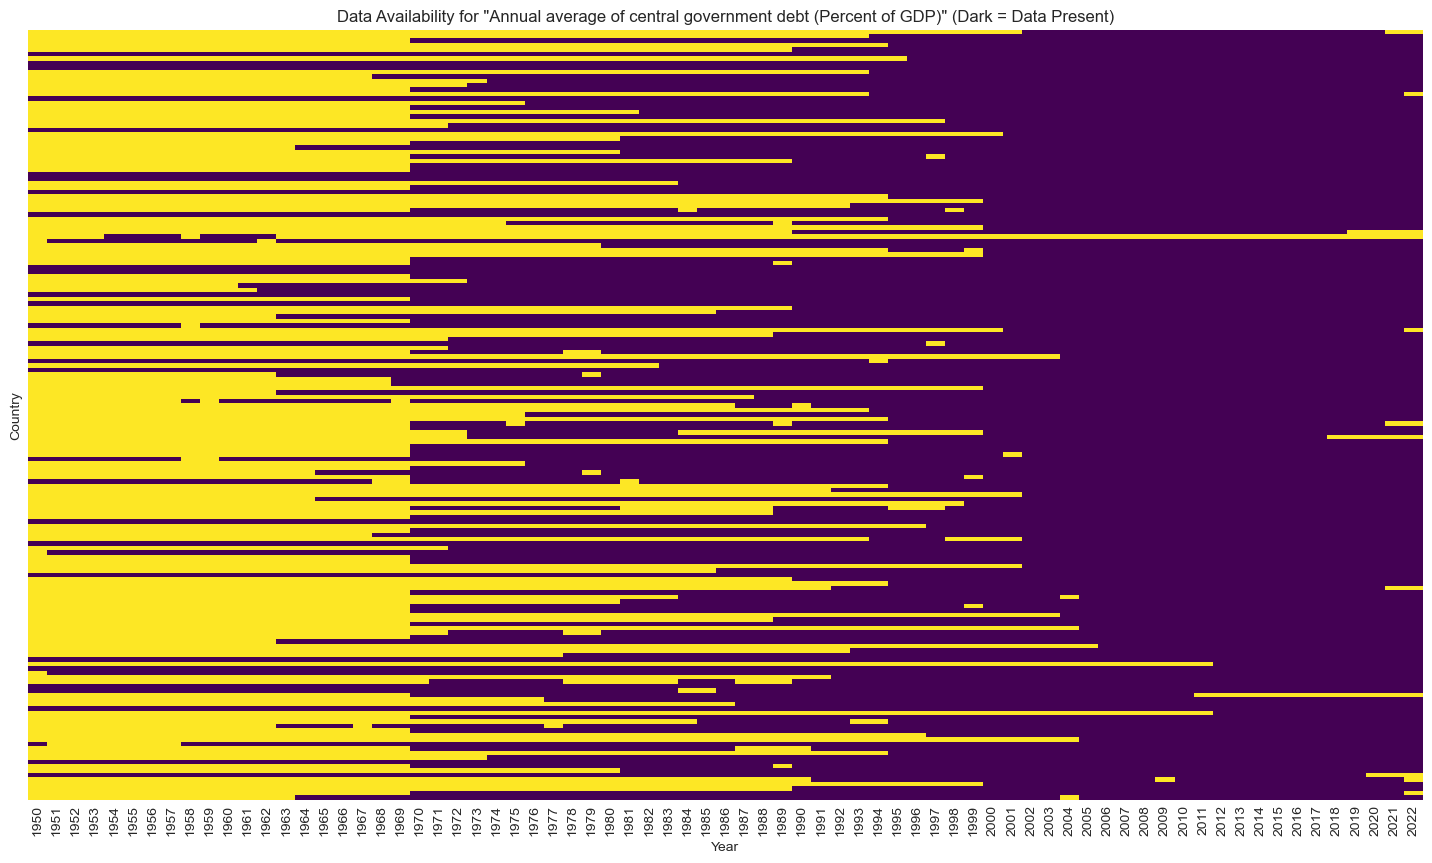

In [5]:
if not processed_debt_df.empty:
    print("--- Missing Value Analysis (Reshaped Data) ---")
    missing_values = processed_debt_df['Debt_Percentage'].isnull().sum()
    total_entries = len(processed_debt_df)
    if total_entries > 0:
        percentage_missing = (missing_values / total_entries) * 100
        print(f"Total missing 'Debt_Percentage' values: {missing_values} ({percentage_missing:.2f}% of total entries)")
    else:
        print("Processed dataframe is empty, cannot analyze missing values.")

    print("\n--- Data Coverage Overview ---")
    if 'Year' in processed_debt_df.columns and not processed_debt_df['Year'].empty:
        min_year, max_year = processed_debt_df['Year'].min(), processed_debt_df['Year'].max()
        print(f"Time period covered: {min_year} to {max_year}")
    else:
        print("Year information not available or empty.")
        
    if 'country_name' in processed_debt_df.columns:
        print(f"Number of unique countries/territories: {processed_debt_df['country_name'].nunique()}")
    else:
        print("Country name information not available.")
        
    if 'indicator_name' in processed_debt_df.columns:
        num_unique_indicators = processed_debt_df['indicator_name'].nunique()
        print(f"Number of unique indicators: {num_unique_indicators}")
        print("\nUnique Indicator Names found (sample):")
        unique_indicators_sample = processed_debt_df['indicator_name'].unique()
        for indicator in unique_indicators_sample[:min(10, len(unique_indicators_sample))]: # Display up to 10
            print(f"- {indicator}")
        if len(unique_indicators_sample) > 10:
            print(f"... and {len(unique_indicators_sample) - 10} more.")
        
        # Tries to find the main debt measure to focus on for some analyses
        possible_main_debt_indicators = [
            "Central government debt, total (% of GDP)", # Most likely for this file
            "General government gross debt (% of GDP)",
            "GG deuda bruta (% del PIB)", # Spanish version often found in global datasets
            "Deuda del gobierno central, total (% del PIB)", # Spanish
            "Annual average of central government debt (Percent of GDP)" # From earlier user context
            # Add other common phrasings if known
        ]
        
        main_debt_indicator = None
        available_indicators = processed_debt_df['indicator_name'].dropna().unique()
        for ind_pattern in possible_main_debt_indicators:
            for actual_ind in available_indicators:
                if ind_pattern.lower() in actual_ind.lower(): # Partial match to be more robust
                    main_debt_indicator = actual_ind
                    break
            if main_debt_indicator:
                break
        
        main_indicator_debt_df = pd.DataFrame() # Initialize
        if main_debt_indicator:
            print(f"\nIdentified a potential main debt indicator for focused analysis: '{main_debt_indicator}'")
            main_indicator_debt_df = processed_debt_df[processed_debt_df['indicator_name'] == main_debt_indicator].copy()
            main_indicator_debt_df.dropna(subset=['Debt_Percentage'], inplace=True)
        else:
            print("\nWarning: Could not automatically identify a common main debt indicator. Some focused analyses might be affected or use a fallback.")
            # If a specific indicator cannot be found, pick the one with the most data available
            if not processed_debt_df.dropna(subset=['Debt_Percentage']).empty:
                indicator_counts = processed_debt_df.dropna(subset=['Debt_Percentage'])['indicator_name'].value_counts()
                if not indicator_counts.empty:
                    fallback_indicator = indicator_counts.index[0]
                    print(f"Using fallback indicator (most data points): '{fallback_indicator}' for some specific plots.")
                    main_indicator_debt_df = processed_debt_df[processed_debt_df['indicator_name'] == fallback_indicator].copy()
                    main_indicator_debt_df.dropna(subset=['Debt_Percentage'], inplace=True)
                else:
                    print("No indicators with data points found to select a fallback.")
            else:
                print("No non-NaN debt percentages found to determine a fallback indicator.")
    else:
        print("Indicator name information not available.")
        main_indicator_debt_df = pd.DataFrame() # Ensure defined

# Show a heatmap of data availability - only creates this if 'main_indicator_debt_df' exists and has data
if not main_indicator_debt_df.empty and 'country_name' in main_indicator_debt_df.columns and 'Year' in main_indicator_debt_df.columns:
    current_indicator_for_heatmap = main_indicator_debt_df['indicator_name'].iloc[0]
    print(f"\nGenerating data availability heatmap for indicator: '{current_indicator_for_heatmap}'")
    try:
        availability_pivot = main_indicator_debt_df.pivot_table(
            values='Debt_Percentage', 
            index='country_name',       # Underscore removed from here
            columns='Year', 
            aggfunc='count'             # Use 'count' or 'size' to see if a value exists
        )
        plt.figure(figsize=(18, 10)) # Adjusted size
        sns.heatmap(availability_pivot.notna(), cbar=False, cmap="viridis_r") # Use notna() to show True/False
        plt.title(f'Data Availability for "{current_indicator_for_heatmap}" (Dark = Data Present)')
        plt.ylabel('Country')
        plt.xlabel('Year')
        # Adjust y-ticks for readability
        if len(availability_pivot.index) > 60:
            plt.yticks([]) # Hide y-ticks if too crowded
        elif len(availability_pivot.index) > 30:
            plt.yticks(fontsize=8)
        plt.show()
    except Exception as e:
        print(f"Could not generate data availability heatmap: {e}")
        print("This might happen if there are too many unique country/year combinations for pivoting or other data issues.")
else:
    print("\nSkipping data availability heatmap: No suitable 'main_indicator_debt_df' available or it's empty.")

In [6]:
try:
    # Try UTF-8 first (most common)
    debt_data = pd.read_csv('central_government_debt.csv')
except UnicodeDecodeError:
    # Fall back to Latin-1 if UTF-8 fails
    debt_data = pd.read_csv('central_government_debt.csv', encoding='latin-1')

# Load other datasets (with similar encoding handling)
try:
    gdp_data = pd.read_csv('world GDP 1960-2022.csv')
except UnicodeDecodeError:
    gdp_data = pd.read_csv('world GDP 1960-2022.csv', encoding='latin-1')

try:
    population_data = pd.read_csv('world population from 1960 to 2023.csv')
except UnicodeDecodeError:
    population_data = pd.read_csv('world population from 1960 to 2023.csv', encoding='latin-1')


# Standardize Country Names (Important for Merging)
def clean_country_names(df):
    """Ensure country names are consistent across datasets."""
    if 'country_name' in df.columns:
        df['country_name'] = df['country_name'].str.strip().str.title()
    if 'country_code' in df.columns:
        df['country_code'] = df['country_code'].str.strip().str.upper()
    return df

debt_data = clean_country_names(debt_data)
gdp_data = clean_country_names(gdp_data)
population_data = clean_country_names(population_data)

# Handle Missing Data - GDP Data: Forward-fill missing years
gdp_data_cleaned = gdp_data.ffill(axis=1)

# Population Data: Drop entirely missing rows
population_data_cleaned = population_data.dropna(
    how='all', 
    subset=population_data.columns[4:]  # Skip metadata columns
)

# Debt Data: Drop rows with >50% missing years
threshold = len(debt_data.columns[2:]) // 2  # Skip country_name and indicator_name
debt_data_cleaned = debt_data.dropna(
    thresh=threshold + 2,  # +2 for the non-year columns
    subset=debt_data.columns[2:]
)

# Make sure all datasets cover the same years - Find the years they all have in common (Debt: 1950-2022, GDP: 1960-2022, Population: 1960-2023)
common_years = sorted(list(
    set(debt_data.columns[2:])  # Debt years (skip country_name and indicator_name)
    .intersection(gdp_data.columns[2:])  # GDP years
    .intersection(population_data.columns[4:])  # Population years
))

# Filter all datasets to these years
debt_data_cleaned = debt_data_cleaned[['country_name', 'indicator_name'] + common_years]
gdp_data_cleaned = gdp_data_cleaned[['country_name', 'country_code'] + common_years]
population_data_cleaned = population_data_cleaned[['country_name', 'country_code', 'region', 'income_group'] + common_years]

# Change debt data to long format (better for time-series analysis) - This data shows central government debt as a percentage of GDP
debt_long = debt_data_cleaned.melt(
    id_vars=['country_name', 'indicator_name'],
    var_name='year',
    value_name='debt_pct_gdp'
).query("indicator_name == 'Annual average of central government debt (Percent of GDP)'")

# GDP Data
gdp_long = gdp_data_cleaned.melt(
    id_vars=['country_name', 'country_code'],
    var_name='year',
    value_name='gdp'
)

# Population Data
id_cols = [col for col in ['country_name', 'country_code', 'region', 'income_group'] 
           if col in population_data_cleaned.columns]
population_long = population_data_cleaned.melt(
    id_vars=id_cols,
    var_name='year',
    value_name='population'
)

# Calculate Absolute Debt Values 
# Make sure the data is in number format first
debt_long['debt_pct_gdp'] = pd.to_numeric(debt_long['debt_pct_gdp'], errors='coerce')
gdp_long['gdp'] = pd.to_numeric(gdp_long['gdp'], errors='coerce')

# Merge GDP and Debt data to calculate absolute debt values
debt_absolute = pd.merge(
    debt_long,
    gdp_long,
    on=['country_name', 'year'],
    how='inner'
)

# Calculate debt amount
debt_absolute['debt_amount'] = (debt_absolute['gdp'] * debt_absolute['debt_pct_gdp'] / 100)

# Format currency for absolute debt
def format_currency(x):
    if pd.isna(x):
        return "NA"
    if x >= 1e12: return f"${x/1e12:.2f}T"
    elif x >= 1e9: return f"${x/1e9:.2f}B"
    elif x >= 1e6: return f"${x/1e6:.2f}M"
    else: return f"${x:,.2f}"

debt_absolute['debt_formatted'] = debt_absolute['debt_amount'].apply(format_currency)

# Validation Checks
print("=== Final Validation ===")
print("Unique Countries in Debt Data:", debt_long['country_name'].nunique())
print("Unique Countries in GDP Data:", gdp_long['country_name'].nunique())
print("Unique Countries in Population Data:", population_long['country_name'].nunique())
print("\nTime Period Coverage:", min(common_years), "to", max(common_years))
print("\nSample Debt Values (% of GDP):")
print(debt_long['debt_pct_gdp'].describe().apply(lambda x: f"{x:,.2f}"))
print("\nSample GDP Values:")
print(gdp_long['gdp'].describe().apply(lambda x: f"{x:,.2f}"))
print("\nData Types:")
print("Debt pct:", debt_long['debt_pct_gdp'].dtype)
print("GDP:", gdp_long['gdp'].dtype)

=== Final Validation ===
Unique Countries in Debt Data: 114
Unique Countries in GDP Data: 266
Unique Countries in Population Data: 263

Time Period Coverage: 1960 to 2022

Sample Debt Values (% of GDP):
count    6,212.00
mean        48.12
std         41.22
min          0.02
25%         21.28
50%         38.33
75%         61.12
max        677.18
Name: debt_pct_gdp, dtype: object

Sample GDP Values:
count                 13,550.00
mean       1,190,896,611,875.74
std        5,377,418,918,201.57
min                8,824,746.24
25%            2,482,435,260.50
50%           17,746,865,111.50
75%          217,989,144,459.25
max      100,562,011,134,034.00
Name: gdp, dtype: object

Data Types:
Debt pct: float64
GDP: float64


## 3. Overall Debt Percentage Analysis

This section explores general trends and distributions of central government debt percentages.illll look at how these percentages vary globally and over time, and identify countries with particularly high or low debt ratios for specific indicatorsP primarily use the main debt indicator identified in the previous section for these overall analyses.

### 3.1 Global Trends and Recent Year Snapshot 


--- Overall Debt Percentage Analysis for Indicator: Annual average of central government debt (Percent of GDP) ---

Analysis for the year 2022 (Indicator: 'Annual average of central government debt (Percent of GDP)'):
Data available for 161 countries.
Average Debt Percentage: 62.1
Median Debt Percentage: 54.3


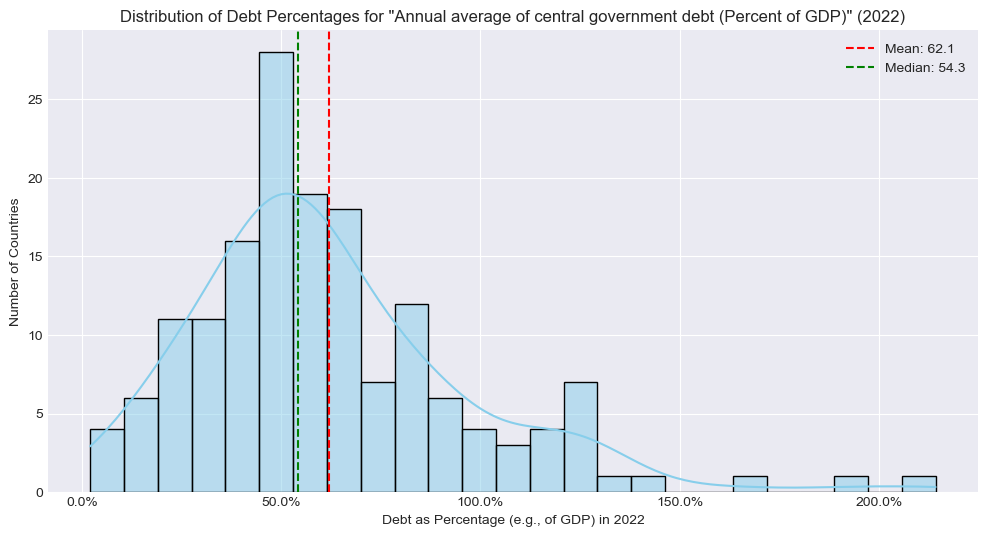

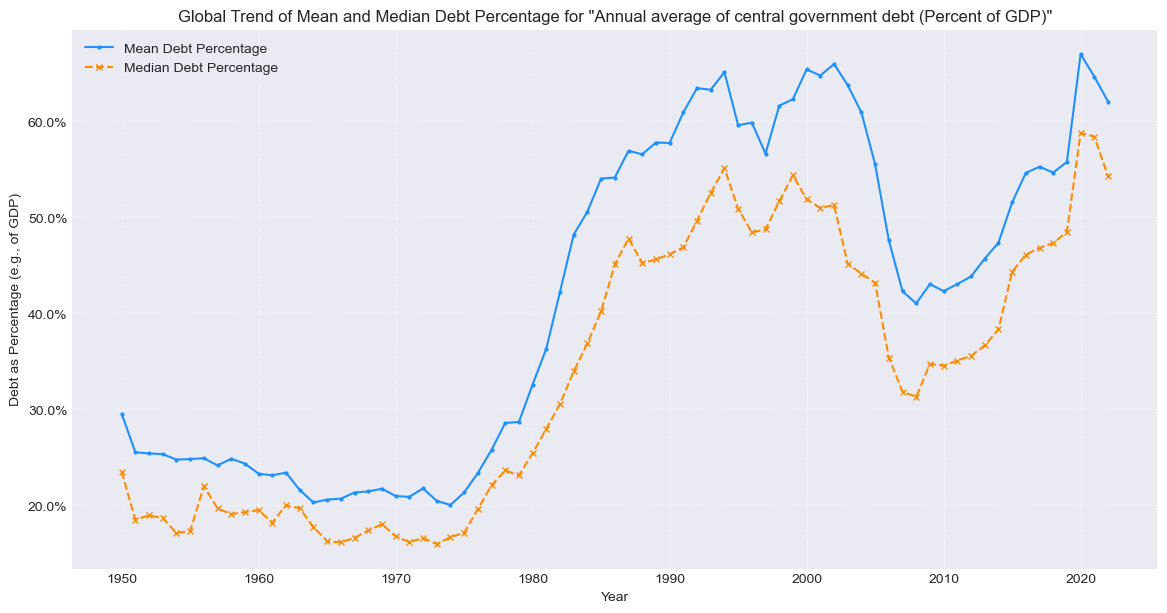

In [7]:
if 'main_indicator_debt_df' not in locals() or main_indicator_debt_df.empty:
    print("Warning: 'main_indicator_debt_df' is not available or is empty. Attempting to use 'processed_debt_df' with a fallback or first available indicator.")
    if 'processed_debt_df' not in locals() or processed_debt_df.empty:
        print("Error: 'processed_debt_df' is also empty. Cannot proceed with Overall Debt Percentage Analysis.")
        # Make an empty dataframe to prevent errors later if needed
        debt_latest_year = pd.DataFrame() 
        global_trend_df_for_analysis = pd.DataFrame()
    else:
        if not processed_debt_df.dropna(subset=['Debt_Percentage']).empty:
            indicator_counts = processed_debt_df.dropna(subset=['Debt_Percentage'])['indicator_name'].value_counts()
            if not indicator_counts.empty:
                fallback_indicator_name = indicator_counts.index[0]
                print(f"Using fallback indicator for overall analysis: '{fallback_indicator_name}'")
                global_trend_df_for_analysis = processed_debt_df[processed_debt_df['indicator_name'] == fallback_indicator_name].copy()
                global_trend_df_for_analysis.dropna(subset=['Debt_Percentage'], inplace=True)
            else:
                print("No indicators with data points found in processed_debt_df.")
                global_trend_df_for_analysis = pd.DataFrame()
                debt_latest_year = pd.DataFrame()
        else:
            print("No non-NaN debt percentages in processed_debt_df.")
            global_trend_df_for_analysis = pd.DataFrame()
            debt_latest_year = pd.DataFrame()
else:
    global_trend_df_for_analysis = main_indicator_debt_df.copy() # Use the specifically identified main indicator data

if not global_trend_df_for_analysis.empty:
    current_indicator_name = global_trend_df_for_analysis['indicator_name'].iloc[0]
    print(f"--- Overall Debt Percentage Analysis for Indicator: {current_indicator_name} ---")
    
    latest_year_overall = global_trend_df_for_analysis['Year'].max()
    debt_latest_year = global_trend_df_for_analysis[global_trend_df_for_analysis['Year'] == latest_year_overall].copy()

    if not debt_latest_year.empty:
        avg_debt_percentage_latest_year = debt_latest_year['Debt_Percentage'].mean()
        median_debt_percentage_latest_year = debt_latest_year['Debt_Percentage'].median()
        num_countries_latest_year = debt_latest_year['country_name'].nunique()
            
        print(f"\nAnalysis for the year {latest_year_overall} (Indicator: '{current_indicator_name}'):")
        print(f"Data available for {num_countries_latest_year} countries.")
        print(f"Average Debt Percentage: {format_percentage(avg_debt_percentage_latest_year)}")
        print(f"Median Debt Percentage: {format_percentage(median_debt_percentage_latest_year)}")

        # Show how debt percentages are spread out in the most recent year
        plt.figure(figsize=(12, 6))
        sns.histplot(debt_latest_year['Debt_Percentage'], kde=True, bins=25, color="skyblue", edgecolor="black")
        plt.title(f'Distribution of Debt Percentages for "{current_indicator_name}" ({latest_year_overall})')
        plt.xlabel(f'Debt as Percentage (e.g., of GDP) in {latest_year_overall}')
        plt.ylabel('Number of Countries')
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: format_percentage(x, p, is_percentage=True)))
        
        if pd.notna(avg_debt_percentage_latest_year):
            plt.axvline(avg_debt_percentage_latest_year, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {format_percentage(avg_debt_percentage_latest_year)}')
        if pd.notna(median_debt_percentage_latest_year):
            plt.axvline(median_debt_percentage_latest_year, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {format_percentage(median_debt_percentage_latest_year)}')
        
        if pd.notna(avg_debt_percentage_latest_year) or pd.notna(median_debt_percentage_latest_year):
            plt.legend()
        plt.show()
    else:
        print(f"\nNo data available for '{current_indicator_name}' in the latest year {latest_year_overall} to show distribution.")
        # Make sure debt_latest_year is empty here if needed, so later code won’t break
        debt_latest_year = pd.DataFrame()
        
    global_mean_trend = global_trend_df_for_analysis.groupby('Year')['Debt_Percentage'].mean().dropna()
    global_median_trend = global_trend_df_for_analysis.groupby('Year')['Debt_Percentage'].median().dropna()

    if not global_mean_trend.empty:
        plt.figure(figsize=(14, 7))
        global_mean_trend.plot(label='Mean Debt Percentage', color='dodgerblue', marker='.', markersize=4)
        global_median_trend.plot(label='Median Debt Percentage', color='darkorange', linestyle='--', marker='x', markersize=4)
        plt.title(f'Global Trend of Mean and Median Debt Percentage for "{current_indicator_name}"')
        plt.ylabel('Debt as Percentage (e.g., of GDP)')
        plt.xlabel('Year')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format_percentage(x, p, is_percentage=True)))
        plt.legend()
        plt.grid(True, which='both', linestyle=':', linewidth=0.7)
        plt.show()
    else:
        print(f"Not enough data to plot global trend for '{current_indicator_name}'.")
        
elif 'processed_debt_df' in locals() and not processed_debt_df.empty and 'Debt_Percentage' in processed_debt_df.columns:
    # This is a fallback if 'main_indicator_debt_df' was empty but 'processed_debt_df' is not
    print("\nWarning: Main debt indicator data was insufficient. Attempting a generic analysis using all available data (which might mix different indicators).")
    generic_global_trend = processed_debt_df.groupby('Year')['Debt_Percentage'].mean().dropna()
    if not generic_global_trend.empty:
        plt.figure(figsize=(14, 7))
        generic_global_trend.plot(label='Mean Debt Percentage (All Indicators Aggregated)', color='mediumseagreen', marker='.')
        plt.title(f'Global Trend of Average Debt Percentage (All Indicators Aggregated)')
        plt.ylabel('Debt as Percentage')
        plt.xlabel('Year')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format_percentage(x, p, is_percentage=True)))
        plt.legend()
        plt.grid(True, which='both', linestyle=':', linewidth=0.7)
        plt.show()
    else:
        print("No data available to plot a generic global trend from 'processed_debt_df'.")
    # If we have to use this fallback, set debt_latest_year empty to avoid errors later
    debt_latest_year = pd.DataFrame()
else:
    print("Skipping Overall Debt Percentage Analysis as 'processed_debt_df' is empty or lacks necessary columns.")
    # Define debt_latest_year as empty if there is no data at all
    debt_latest_year = pd.DataFrame()

### 3.2 Country-Level Rankings and Trends


--- Country-Level Debt Percentage Analysis for 'Annual average of central government debt (Percent of GDP)' (2022) ---

Top 10 Countries by Debt Percentage:


,country_name,Debt_Percentage
12534,Japan,214.3
12515,Greece,192.4
12505,Eritrea,163.8
12532,Italy,140.6
12593,Singapore,135.9
12542,Lao P.D.R.,128.5
12601,Sudan,127.6
12483,Cabo Verde,127.4
12469,Barbados,126.8
12474,Bhutan,124.8


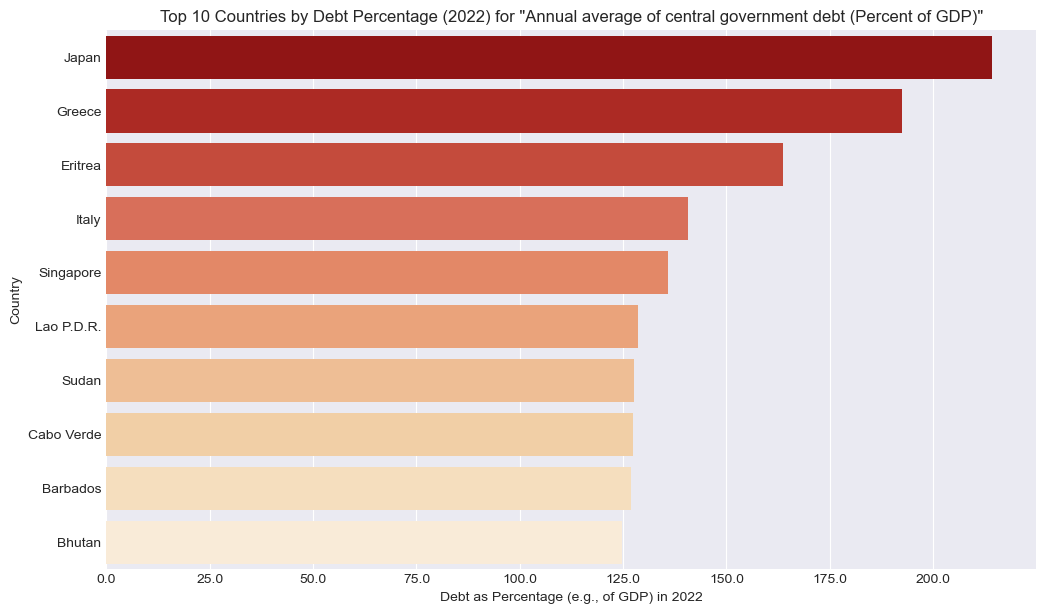


Bottom 10 Countries by Debt Percentage:


,country_name,Debt_Percentage
12479,Brunei Darussalam,2.1
12540,Kuwait,2.9
12614,Turkmenistan,5.2
12615,Tuvalu,7.6
12571,Norway,13.2
12604,Switzerland,14.4
12538,Kiribati,15.2
12609,Timor-Leste,16.3
12596,Solomon Islands,16.9
12506,Estonia,18.8


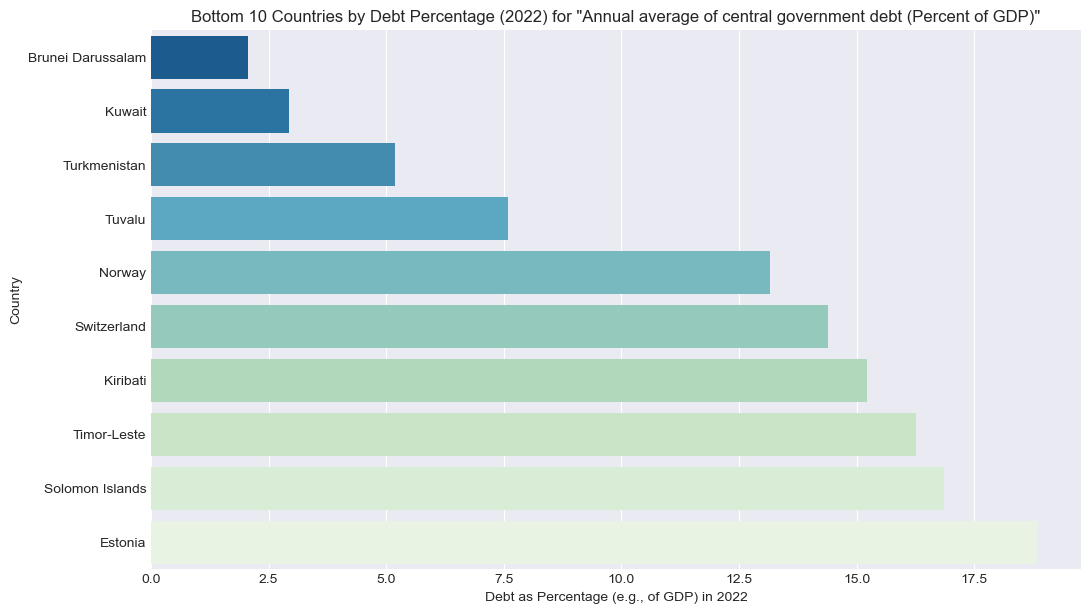

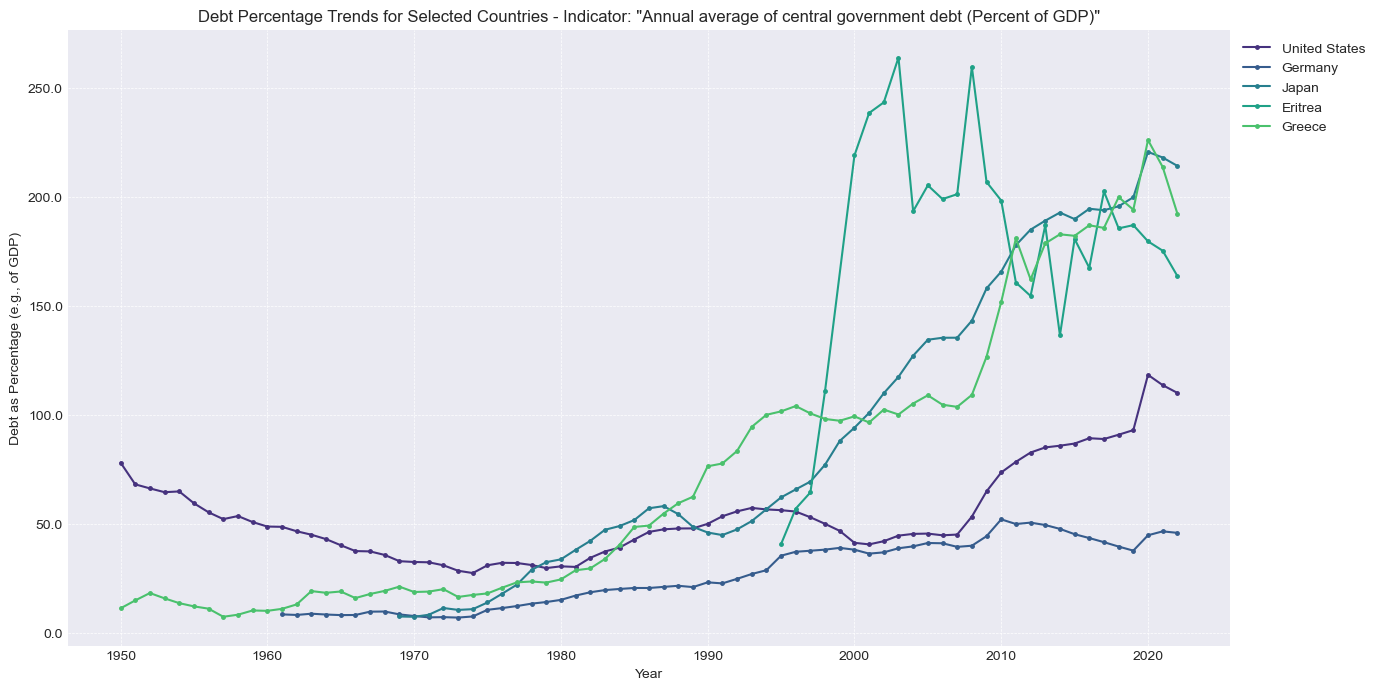

In [8]:
if not main_indicator_debt_df.empty and not debt_latest_year.empty:
    print(f"\n--- Country-Level Debt Percentage Analysis for '{main_indicator_debt_df['indicator_name'].iloc[0]}' ({latest_year_overall}) ---")

    # Top 10 Countries by Debt Percentage
    top_10_countries = debt_latest_year.sort_values(by='Debt_Percentage', ascending=False).head(10)
    print("\nTop 10 Countries by Debt Percentage:")
    display(top_10_countries[['country_name', 'Debt_Percentage']].style.format({'Debt_Percentage': format_percentage}))

    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_10_countries, x='Debt_Percentage', y='country_name', palette='OrRd_r')
    plt.title(f'Top 10 Countries by Debt Percentage ({latest_year_overall}) for "{main_indicator_debt_df["indicator_name"].iloc[0]}"')
    plt.xlabel(f'Debt as Percentage (e.g., of GDP) in {latest_year_overall}')
    plt.ylabel('Country')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_percentage))
    plt.show()

    # Bottom 10 Countries by Debt Percentage
    bottom_10_countries = debt_latest_year.sort_values(by='Debt_Percentage', ascending=True).head(10)
    print("\nBottom 10 Countries by Debt Percentage:")
    display(bottom_10_countries[['country_name', 'Debt_Percentage']].style.format({'Debt_Percentage': format_percentage}))
    
    plt.figure(figsize=(12, 7))
    sns.barplot(data=bottom_10_countries, x='Debt_Percentage', y='country_name', palette='GnBu_r')
    plt.title(f'Bottom 10 Countries by Debt Percentage ({latest_year_overall}) for "{main_indicator_debt_df["indicator_name"].iloc[0]}"')
    plt.xlabel(f'Debt as Percentage (e.g., of GDP) in {latest_year_overall}')
    plt.ylabel('Country')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_percentage))
    plt.show()
    
    if not main_indicator_debt_df.empty:
        countries_to_plot = top_10_countries['country_name'].unique()[:3].tolist() # Top 3
        example_economies = ['United States', 'China', 'Germany', 'Japan', 'India', 'Brazil']
        available_examples = [c for c in example_economies if c in main_indicator_debt_df['country_name'].unique()]
        countries_to_plot.extend(available_examples[:2]) # Add up to 2 example economies
        countries_to_plot = list(set(countries_to_plot)) # Unique list
        
        if countries_to_plot:
            plt.figure(figsize=(15, 8))
            for country in countries_to_plot:
                country_trend = main_indicator_debt_df[main_indicator_debt_df['country_name'] == country].set_index('Year')['Debt_Percentage']
                if not country_trend.empty:
                     country_trend.plot(label=country, marker='.', markersize=5)
            
            plt.title(f'Debt Percentage Trends for Selected Countries - Indicator: "{main_indicator_debt_df["indicator_name"].iloc[0]}"')
            plt.ylabel('Debt as Percentage (e.g., of GDP)')
            plt.xlabel('Year')
            plt.gca().yaxis.set_major_formatter(FuncFormatter(format_percentage))
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.show()
        else:
            print("\nCould not select any countries for trend plotting based on available data.")
            
elif not processed_debt_df.empty and 'Debt_Percentage' in processed_debt_df.columns:
    print("\nWarning: Main debt indicator not specifically identified or its latest year data is empty.")
    print("Country-level analysis for a specific indicator and year cannot be performed as shown above.")
    print("Consider exploring different indicators or years if `main_indicator_debt_df` is not adequately populated.")
else:
    print("Skipping Country-Level Debt Percentage Analysis as data is insufficient.")

### 3.3  Temporal Analysis (Assuming Data Has Time Component)

In [9]:
import pandas as pd
from IPython.display import display

print("--- Load and Prepare Population Data ---")

population_raw_df = pd.DataFrame() # Initialize as empty
actual_population_filename = 'world population from 1960 to 2023.csv' 

try:
    print(f"Attempting to load '{actual_population_filename}' with UTF-8 encoding...")
    population_raw_df = pd.read_csv(actual_population_filename)
    print(f"Successfully loaded '{actual_population_filename}' (using default UTF-8 or specified encoding).")
except UnicodeDecodeError:
    print(f"UTF-8 decoding failed for '{actual_population_filename}', trying 'latin1' encoding...")
    try:
        population_raw_df = pd.read_csv(actual_population_filename, encoding='latin1')
        print(f"Successfully loaded '{actual_population_filename}' (using latin1 encoding).")
    except Exception as e_latin1:
        print(f"Failed to load '{actual_population_filename}' with 'latin1' as well. Error: {e_latin1}")
except FileNotFoundError:
    print(f"Error: '{actual_population_filename}' not found. Please ensure the file is in the correct directory and the name is exact.")
except Exception as e_outer:
    print(f"An error occurred while loading '{actual_population_filename}': {e_outer}")

population_long_df = pd.DataFrame() # Initialize to ensure it's defined

if not population_raw_df.empty:
    print("\n--- Initial Population Data Overview ---")
    display(population_raw_df.head())
    print("\nPopulation Data Info (Raw):")
    population_raw_df.info()

    # Set ID columns based on the real column names in your CSV
    # These include: 'country_name', 'country_code', 'region', and 'income_group'
    pop_id_vars_from_file = ['country_name', 'country_code', 'region', 'income_group']
    
    # Filter this list to include only columns actually in the DataFrame
    pop_id_vars = [col for col in pop_id_vars_from_file if col in population_raw_df.columns]

    # Check that 'country_name' is in the ID columns we found
    if 'country_name' not in pop_id_vars:
        print("\nCritical Error: 'country_name' column not found or not identified as an ID variable from the population data. This column is essential for merging.")
        print("Available columns in raw data:", population_raw_df.columns.tolist())
        print("Identified ID vars for melt:", pop_id_vars)
    else:
        # Find year columns by looking for column names that are numbers
        # Make sure column names are strings so we can check if they are digits
        pop_year_cols = [col for col in population_raw_df.columns if str(col).isdigit() and 1960 <= int(str(col)) <= 2023]

        if not pop_year_cols:
            print("\nError: No year columns (e.g., '1960', '2023') found in population data. Please inspect columns.")
        else:
            print(f"\nIdentified ID variables for population data: {pop_id_vars}")
            print(f"Identified Year columns for population data: {len(pop_year_cols)} (e.g., from {pop_year_cols[0]} to {pop_year_cols[-1]})")

            population_long_df = pd.melt(population_raw_df,
                                         id_vars=pop_id_vars,
                                         value_vars=pop_year_cols,
                                         var_name='Year',
                                         value_name='Population')
            
            # 'country_name' column should be fine as is
            # No need to rename 'country_name' if it’s already named that
            # This CSV doesn’t have an 'Indicator Name' column to filter

            
            population_long_df['Year'] = pd.to_numeric(population_long_df['Year'])
            population_long_df['Population'] = pd.to_numeric(population_long_df['Population'], errors='coerce')
            
            # Remove rows with missing Population data since we can’t calculate per person values without it
            population_long_df.dropna(subset=['Population'], inplace=True)
            
            # Pick the final columns we want and keep them in the right order
            final_pop_cols_to_keep = ['country_name', 'Year', 'Population']
            if 'country_code' in pop_id_vars:
                final_pop_cols_to_keep.append('country_code')
            if 'region' in pop_id_vars:
                final_pop_cols_to_keep.append('region')
            if 'income_group' in pop_id_vars:
                final_pop_cols_to_keep.append('income_group')
            
            # Keep only these columns if they are in population_long_df
            actual_cols_present = [col for col in final_pop_cols_to_keep if col in population_long_df.columns]
            population_long_df = population_long_df[actual_cols_present]

            print("\n--- Processed Population Data (Long Format) ---")
            if not population_long_df.empty:
                display(population_long_df.head())
                print("\nPopulation Data Info (Processed):")
                population_long_df.info()
                if 'Population' in population_long_df.columns:
                    print("\nDescriptive statistics for 'Population':")
                    display(population_long_df['Population'].describe())
            else:
                print("Population data became empty after processing (e.g., all NaNs or filtering).")
else:
    print("\nSkipping population data processing as loading failed or resulted in an empty DataFrame.")
    # population_long_df was already initialized as empty


--- Starting 8.1: Load and Prepare Population Data ---
Attempting to load 'world population from 1960 to 2023.csv' with UTF-8 encoding...
Successfully loaded 'world population from 1960 to 2023.csv' (using default UTF-8 or specified encoding).

--- Initial Population Data Overview ---


,country_code,country_name,region,income_group,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,ABW,ARUBA,NaN,INGRESO ALTO,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,106277.0
1,AFE,NaN,NaN,AGREGADOS,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,739108306.0
2,AFG,AFGANISTÁN,ASIA MERIDIONAL,PAÍSES DE INGRESO BAJO,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0
3,AFW,NaN,NaN,AGREGADOS,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,502789511.0
4,AGO,ANGOLA,ÁFRICA AL SUR DEL SAHARA (EXCLUIDO ALTOS INGRE...,PAÍSES DE INGRESO MEDIANO BAJO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,36684202.0



Population Data Info (Raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  266 non-null    object 
 1   country_name  264 non-null    object 
 2   region        131 non-null    object 
 3   income_group  266 non-null    object 
 4   1960          264 non-null    float64
 5   1961          264 non-null    float64
 6   1962          264 non-null    float64
 7   1963          264 non-null    float64
 8   1964          264 non-null    float64
 9   1965          264 non-null    float64
 10  1966          264 non-null    float64
 11  1967          264 non-null    float64
 12  1968          264 non-null    float64
 13  1969          264 non-null    float64
 14  1970          264 non-null    float64
 15  1971          264 non-null    float64
 16  1972          264 non-null    float64
 17  1973          264 non-null    float64
 18  1

,country_name,Year,Population,country_code,region,income_group
0,ARUBA,1960,54608.0,ABW,NaN,INGRESO ALTO
1,NaN,1960,130692579.0,AFE,NaN,AGREGADOS
2,AFGANISTÁN,1960,8622466.0,AFG,ASIA MERIDIONAL,PAÍSES DE INGRESO BAJO
3,NaN,1960,97256290.0,AFW,NaN,AGREGADOS
4,ANGOLA,1960,5357195.0,AGO,ÁFRICA AL SUR DEL SAHARA (EXCLUIDO ALTOS INGRE...,PAÍSES DE INGRESO MEDIANO BAJO



Population Data Info (Processed):
<class 'pandas.core.frame.DataFrame'>
Index: 16930 entries, 0 to 17023
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  16802 non-null  object 
 1   Year          16930 non-null  int64  
 2   Population    16930 non-null  float64
 3   country_code  16930 non-null  object 
 4   region        8354 non-null   object 
 5   income_group  16930 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 925.9+ KB

Descriptive statistics for 'Population':


count    1.693000e+04
mean     2.159717e+08
std      7.093387e+08
min      2.646000e+03
25%      1.010372e+06
50%      6.765644e+06
75%      4.664624e+07
max      8.024997e+09
Name: Population, dtype: float64

In [10]:
# --- Load and Prepare GDP Data ---
import pandas as pd 
from IPython.display import display

print("--- Load and Prepare GDP Data ---")

gdp_raw_df = pd.DataFrame() # Initialize as empty
actual_gdp_filename = 'World GDP 1960-2022.csv' # Define the filename

try:
    print(f"Attempting to load '{actual_gdp_filename}' with UTF-8 encoding...")
    gdp_raw_df = pd.read_csv(actual_gdp_filename)
    print(f"Successfully loaded '{actual_gdp_filename}' (using default UTF-8 or specified encoding).")
except UnicodeDecodeError:
    print(f"UTF-8 decoding failed for '{actual_gdp_filename}', trying 'latin1' encoding...")
    try:
        gdp_raw_df = pd.read_csv(actual_gdp_filename, encoding='latin1')
        print(f"Successfully loaded '{actual_gdp_filename}' (using latin1 encoding).")
    except Exception as e_latin1:
        print(f"Failed to load '{actual_gdp_filename}' with 'latin1' as well. Error: {e_latin1}")
except FileNotFoundError:
    print(f"Error: '{actual_gdp_filename}' not found. Please ensure the file is in the correct directory and the name is exact.")
except Exception as e_outer:
    print(f"An error occurred while loading '{actual_gdp_filename}': {e_outer}")

gdp_long_df = pd.DataFrame()

if not gdp_raw_df.empty:
    print("\n--- Initial GDP Data Overview ---")
    display(gdp_raw_df.head())
    print("\nGDP Data Info (Raw):")
    gdp_raw_df.info()

    # Find ID columns. World Bank GDP data usually has 'Country Name', 'Country Code', and 'Indicator Name'
    gdp_id_vars_candidates = {
        'country_name_col': None,
        'country_code_col': None,
        'indicator_name_col': None
    }

    if 'Country Name' in gdp_raw_df.columns: # Common WB naming
        gdp_id_vars_candidates['country_name_col'] = 'Country Name'
    elif 'country_name' in gdp_raw_df.columns: # Fallback
        gdp_id_vars_candidates['country_name_col'] = 'country_name'

    if 'Country Code' in gdp_raw_df.columns:
        gdp_id_vars_candidates['country_code_col'] = 'Country Code'
    elif 'country_code' in gdp_raw_df.columns:
        gdp_id_vars_candidates['country_code_col'] = 'country_code'

    if 'Indicator Name' in gdp_raw_df.columns:
        gdp_id_vars_candidates['indicator_name_col'] = 'Indicator Name'
    elif 'indicator_name' in gdp_raw_df.columns: # Fallback
         gdp_id_vars_candidates['indicator_name_col'] = 'indicator_name'


    if not gdp_id_vars_candidates['country_name_col']:
        print("\nCritical Error: A 'Country Name' or 'country_name' column was not found in GDP data. This column is essential for merging.")
        print("Available columns:", gdp_raw_df.columns.tolist())
    else:
        gdp_id_vars = [col for col in gdp_id_vars_candidates.values() if col is not None]
        
        # Identify year columns (typically strings of digits like '1960')
        gdp_year_cols = [col for col in gdp_raw_df.columns if str(col).isdigit() and 1960 <= int(str(col)) <= 2022]

        if not gdp_year_cols:
            print("\nError: No year columns (e.g., '1960', '2022') found in GDP data. Please inspect columns.")
        else:
            print(f"\nIdentified ID variables for GDP data: {gdp_id_vars}")
            print(f"Identified Year columns for GDP data: {len(gdp_year_cols)} (e.g., from {gdp_year_cols[0]} to {gdp_year_cols[-1]})")

            gdp_long_df = pd.melt(gdp_raw_df,
                                  id_vars=gdp_id_vars,
                                  value_vars=gdp_year_cols,
                                  var_name='Year',
                                  value_name='GDP')
            
            if gdp_id_vars_candidates['country_name_col'] == 'Country Name' and 'Country Name' in gdp_long_df.columns:
                gdp_long_df.rename(columns={'Country Name': 'country_name'}, inplace=True)
            
            if gdp_id_vars_candidates['country_code_col'] == 'Country Code' and 'Country Code' in gdp_long_df.columns:
                gdp_long_df.rename(columns={'Country Code': 'country_code'}, inplace=True)

            actual_indicator_name_col_in_long_df = None
            if gdp_id_vars_candidates['indicator_name_col'] == 'Indicator Name' and 'Indicator Name' in gdp_long_df.columns:
                gdp_long_df.rename(columns={'Indicator Name': 'indicator_name'}, inplace=True)
                actual_indicator_name_col_in_long_df = 'indicator_name'
            elif 'indicator_name' in gdp_long_df.columns: # if it was already lowercase
                actual_indicator_name_col_in_long_df = 'indicator_name'


            gdp_long_df['Year'] = pd.to_numeric(gdp_long_df['Year'])
            gdp_long_df['GDP'] = pd.to_numeric(gdp_long_df['GDP'], errors='coerce')
            
            gdp_long_df.dropna(subset=['GDP'], inplace=True) # Remove rows where GDP is NaN

            if actual_indicator_name_col_in_long_df:
                unique_gdp_indicators = gdp_long_df[actual_indicator_name_col_in_long_df].unique()
                target_gdp_indicator_pattern = "GDP (current US$)" 
                
                found_target_gdp_indicator = False
                actual_target_gdp_indicator_name = None
                for indicator in unique_gdp_indicators:
                    if str(indicator).strip().lower() == target_gdp_indicator_pattern.lower():
                        actual_target_gdp_indicator_name = indicator # Use exact casing from file
                        found_target_gdp_indicator = True
                        break
                
                if found_target_gdp_indicator:
                    print(f"\nFiltering GDP data for indicator: '{actual_target_gdp_indicator_name}'")
                    gdp_long_df = gdp_long_df[gdp_long_df[actual_indicator_name_col_in_long_df] == actual_target_gdp_indicator_name].copy()
                elif len(unique_gdp_indicators) == 1 and "gdp" in str(unique_gdp_indicators[0]).lower():
                    print(f"\nUsing the only available GDP-related indicator: '{unique_gdp_indicators[0]}'")
                else:
                    print(f"\nWarning: Could not find '{target_gdp_indicator_pattern}' exactly. Available GDP indicators (sample): {unique_gdp_indicators[:5]}")
                    print("Proceeding with potentially mixed or unspecific GDP indicators if multiple exist and none matched 'GDP (current US$)'. This might affect absolute debt calculations if GDP units differ.")
                
                # Choose the final columns, leaving out the indicator name if we already filtered by it
                final_gdp_cols_to_keep = ['country_name', 'Year', 'GDP']
                if 'country_code' in gdp_long_df.columns: # Check if 'country_code' exists after potential rename
                    final_gdp_cols_to_keep.append('country_code')
                
                # Make sure that only existing columns are selected
                actual_cols_present_gdp = [col for col in final_gdp_cols_to_keep if col in gdp_long_df.columns]
                gdp_long_df = gdp_long_df[actual_cols_present_gdp]

            else: 
                print("\nNo 'indicator_name' column found or used for GDP data. Assuming values are directly comparable GDP figures.")
                # Pick the final columns
                final_gdp_cols_to_keep = ['country_name', 'Year', 'GDP']
                if 'country_code' in gdp_long_df.columns:
                     final_gdp_cols_to_keep.append('country_code')
                actual_cols_present_gdp = [col for col in final_gdp_cols_to_keep if col in gdp_long_df.columns]
                gdp_long_df = gdp_long_df[actual_cols_present_gdp]


            print("\n--- Processed GDP Data (Long Format) ---")
            if not gdp_long_df.empty:
                display(gdp_long_df.head())
                print("\nGDP Data Info (Processed):")
                gdp_long_df.info()
                if 'GDP' in gdp_long_df.columns:
                    print("\nDescriptive statistics for 'GDP':")
                    display(gdp_long_df['GDP'].describe())
            else:
                print("GDP data became empty after processing/filtering.")
else:
    print("\nSkipping GDP data processing as loading failed or resulted in an empty DataFrame.")


--- Starting 8.2: Load and Prepare GDP Data ---
Attempting to load 'World GDP 1960-2022.csv' with UTF-8 encoding...
Successfully loaded 'World GDP 1960-2022.csv' (using default UTF-8 or specified encoding).

--- Initial GDP Data Overview ---


,country_name,country_code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.727933e+09,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.276188e+09,3.395794e+09,2.610039e+09,3.126019e+09,NaN
1,Africa Eastern and Southern,AFE,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,3.201437e+10,3.326951e+10,...,9.859871e+11,1.006526e+12,9.273485e+11,8.851764e+11,1.021043e+12,1.007196e+12,1.000834e+12,9.275933e+11,1.081998e+12,1.169484e+12
2,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
3,Africa Western and Central,AFW,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,1.591084e+10,1.451058e+10,...,8.339481e+11,8.943225e+11,7.686447e+11,6.913634e+11,6.848988e+11,7.670257e+11,8.225384e+11,7.864600e+11,8.444597e+11,8.778633e+11
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.334016e+11,1.372444e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10,5.024137e+10,6.568544e+10,1.067136e+11



GDP Data Info (Raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 65 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  266 non-null    object 
 1   country_code  266 non-null    object 
 2   1960          132 non-null    float64
 3   1961          134 non-null    float64
 4   1962          136 non-null    float64
 5   1963          136 non-null    float64
 6   1964          136 non-null    float64
 7   1965          147 non-null    float64
 8   1966          150 non-null    float64
 9   1967          153 non-null    float64
 10  1968          158 non-null    float64
 11  1969          158 non-null    float64
 12  1970          167 non-null    float64
 13  1971          170 non-null    float64
 14  1972          170 non-null    float64
 15  1973          170 non-null    float64
 16  1974          171 non-null    float64
 17  1975          173 non-null    float64
 18  1976    

,country_name,Year,GDP,country_code
1,Africa Eastern and Southern,1960,2.112502e+10,AFE
2,Afghanistan,1960,5.377778e+08,AFG
3,Africa Western and Central,1960,1.044764e+10,AFW
13,Australia,1960,1.860656e+10,AUS
14,Austria,1960,6.592694e+09,AUT



GDP Data Info (Processed):
<class 'pandas.core.frame.DataFrame'>
Index: 13365 entries, 1 to 16757
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  13365 non-null  object 
 1   Year          13365 non-null  int64  
 2   GDP           13365 non-null  float64
 3   country_code  13365 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 522.1+ KB

Descriptive statistics for 'GDP':


count    1.336500e+04
mean     1.206985e+12
std      5.412748e+12
min      8.824746e+06
25%      2.523472e+09
50%      1.842778e+10
75%      2.243835e+11
max      1.005620e+14
Name: GDP, dtype: float64

In [11]:
# --- Merge Datasets and Calculate Key Metrics ---
import pandas as pd # Ensure pandas is imported
from IPython.display import display # For display()

print("--- Merge Datasets and Calculate Key Metrics ---")

# Make sure the needed DataFrames from before exist and have data
debt_data_to_merge = pd.DataFrame() 
data_frames_exist = True 

if 'main_indicator_debt_df' in locals() and not main_indicator_debt_df.empty:
    print("Using 'main_indicator_debt_df' for merging.")
    debt_data_to_merge = main_indicator_debt_df.copy()
elif 'processed_debt_df' in locals() and not processed_debt_df.empty:
    print("Warning: 'main_indicator_debt_df' is not available or is empty. Attempting to use a fallback from 'processed_debt_df'.")
    temp_processed_debt_dropna = processed_debt_df.dropna(subset=['Debt_Percentage'])
    if not temp_processed_debt_dropna.empty:
        indicator_counts = temp_processed_debt_dropna['indicator_name'].value_counts()
        if not indicator_counts.empty:
            fallback_indicator_merge = indicator_counts.index[0]
            print(f"Using fallback indicator for merge: '{fallback_indicator_merge}' from processed_debt_df.")
            debt_data_to_merge = processed_debt_df[processed_debt_df['indicator_name'] == fallback_indicator_merge].copy()
            debt_data_to_merge.dropna(subset=['Debt_Percentage'], inplace=True)
            if debt_data_to_merge.empty:
                print("Warning: Fallback indicator resulted in an empty DataFrame for debt data.")
                data_frames_exist = False
        else:
            print("Error: No indicators with data points found in 'processed_debt_df' to select a fallback.")
            data_frames_exist = False
    else:
        print("Error: 'processed_debt_df' contains no non-NaN 'Debt_Percentage' values to determine a fallback.")
        data_frames_exist = False
else:
    print("Error: Neither 'main_indicator_debt_df' nor 'processed_debt_df' are available or suitable for merging.")
    data_frames_exist = False

if 'population_long_df' not in locals() or population_long_df.empty:
    print("Error: 'population_long_df' (population data) is not available or empty.")
    data_frames_exist = False
if 'gdp_long_df' not in locals() or gdp_long_df.empty:
    print("Error: 'gdp_long_df' (GDP data) is not available or empty.")
    data_frames_exist = False

if debt_data_to_merge.empty and data_frames_exist:
    print("Error: Selected debt data for merging ('debt_data_to_merge') is empty.")
    data_frames_exist = False

merged_df = pd.DataFrame() 

if data_frames_exist:
    print("\nShapes of dataframes before merging:")
    indicator_name_to_print = 'Selected Debt Data'
    if not debt_data_to_merge.empty and 'indicator_name' in debt_data_to_merge.columns and debt_data_to_merge['indicator_name'].nunique() > 0:
        indicator_name_to_print = debt_data_to_merge['indicator_name'].iloc[0]
    
    print(f"  Debt data to merge ('{indicator_name_to_print}'): {debt_data_to_merge.shape}")
    print(f"  Population data: {population_long_df.shape}")
    print(f"  GDP data: {gdp_long_df.shape}")

    # Standardize country names before merging - Create copies to avoid SettingWithCopyWarning if these DFs are used elsewhere
    debt_data_to_merge_std = debt_data_to_merge.copy()
    gdp_long_df_std = gdp_long_df.copy()
    population_long_df_std = population_long_df.copy()

    for df_std in [debt_data_to_merge_std, gdp_long_df_std, population_long_df_std]:
        if 'country_name' in df_std.columns:
            df_std['country_name'] = df_std['country_name'].astype(str).str.strip().str.lower()
        else:
            print(f"Warning: 'country_name' column not found in one of the dataframes during standardization step.")
            # This condition should hopefully not be met if previous checks passed.

    # Pick the needed columns from the cleaned debt data
    debt_cols_for_merge = ['country_name', 'Year', 'Debt_Percentage']
    if 'indicator_name' in debt_data_to_merge_std.columns:
        debt_cols_for_merge.append('indicator_name')
    actual_debt_cols_for_merge = [col for col in debt_cols_for_merge if col in debt_data_to_merge_std.columns]
    debt_subset_df_std = debt_data_to_merge_std[actual_debt_cols_for_merge]

    # Pick the needed columns from standardized GDP data
    gdp_merge_cols = ['country_name', 'Year', 'GDP']
    actual_gdp_merge_cols = [col for col in gdp_merge_cols if col in gdp_long_df_std.columns]
    if 'GDP' not in actual_gdp_merge_cols:
        print("Error: 'GDP' column missing in standardized gdp_long_df. Cannot perform merge.")
        merged_df_temp = pd.DataFrame()
    else:
        print("\nMerging standardized debt data with standardized GDP data...")
        merged_df_temp = pd.merge(debt_subset_df_std, gdp_long_df_std[actual_gdp_merge_cols], 
                                  on=['country_name', 'Year'], how='inner')
    if merged_df_temp.empty:
        print("Warning: Merging debt with GDP resulted in an empty DataFrame even after standardization. Further checks needed for country names and year overlaps.")
    else:
        print(f"Shape after merging debt and GDP (standardized): {merged_df_temp.shape}")
        print("\n--- Pre-merge diagnostics (Debt+GDP vs Population) ---")
        if not merged_df_temp.empty and not population_long_df_std.empty:
            print("Sample standardized country names from Debt+GDP data (merged_df_temp):")
            print(merged_df_temp['country_name'].unique()[:10])
            print("\nSample standardized country names from Population data (population_long_df_std):")
            print(population_long_df_std['country_name'].unique()[:10])

            common_countries = set(merged_df_temp['country_name'].unique()) & set(population_long_df_std['country_name'].unique())
            print(f"\nNumber of common standardized country names between Debt+GDP and Population: {len(common_countries)}")
            if len(common_countries) < 20 and len(common_countries) > 0: # Print if few for easy inspection
                print(f"Common countries: {list(common_countries)[:20]}")
            
            print(f"\nYear range in Debt+GDP data (merged_df_temp): {merged_df_temp['Year'].min()} - {merged_df_temp['Year'].max()}")
            print(f"Year range in Population data (population_long_df_std): {population_long_df_std['Year'].min()} - {population_long_df_std['Year'].max()}")
        # End Debugging

        print("\nMerging with standardized population data...")
        pop_merge_cols = ['country_name', 'Year', 'Population']
        actual_pop_merge_cols = [col for col in pop_merge_cols if col in population_long_df_std.columns]
        if 'Population' not in actual_pop_merge_cols:
            print("Error: 'Population' column missing in standardized population_long_df. Cannot perform merge.")
        else:
            merged_df = pd.merge(merged_df_temp, population_long_df_std[actual_pop_merge_cols],
                                 on=['country_name', 'Year'], how='inner')
            
            if merged_df.empty:
                print("Warning: Merging with population data resulted in an empty DataFrame even after standardization. Check common country names and years (see diagnostics above).")
            else:
                print(f"Shape after merging with population (standardized): {merged_df.shape}")
                print("\n--- Calculating Key Metrics ---")

                merged_df['Absolute_Debt'] = (merged_df['Debt_Percentage'] / 100) * merged_df['GDP']
                merged_df['Debt_Per_Capita'] = merged_df['Absolute_Debt'] / merged_df['Population']
                merged_df['GDP_Per_Capita'] = merged_df['GDP'] / merged_df['Population']
                merged_df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

                print("\n--- Final Merged DataFrame with Calculated Metrics (Sample) ---")
                display(merged_df.head())
                
                print("\nInfo for the final merged DataFrame:")
                merged_df.info()

                print("\nDescriptive statistics for calculated metrics:")
                cols_to_describe = [col for col in ['Absolute_Debt', 'Debt_Per_Capita', 'GDP_Per_Capita'] if col in merged_df.columns]
                if cols_to_describe:
                    display(merged_df[cols_to_describe].describe())
                else:
                    print("Calculated metric columns are not present in the merged DataFrame.")
else:
    print("\nSkipping merge and metric calculation due to missing or empty prerequisite DataFrames or unusable debt data.")



--- Starting 8.3: Merge Datasets and Calculate Key Metrics ---
Using 'main_indicator_debt_df' for merging.

Shapes of dataframes before merging:
  Debt data to merge ('Annual average of central government debt (Percent of GDP)'): (8116, 4)
  Population data: (16930, 6)
  GDP data: (13365, 4)

Merging standardized debt data with standardized GDP data...
Shape after merging debt and GDP (standardized): (6890, 5)

--- Pre-merge diagnostics (Debt+GDP vs Population) ---
Sample standardized country names from Debt+GDP data (merged_df_temp):
['australia' 'austria' 'belgium' 'brazil' 'chile' 'colombia' 'costa rica'
 'finland' 'france' 'greece']

Sample standardized country names from Population data (population_long_df_std):
['aruba' 'nan' 'afganistán' 'angola' 'albania' 'andorra' 'el mundo árabe'
 'emiratos árabes unidos' 'argentina' 'armenia']

Number of common standardized country names between Debt+GDP and Population: 76

Year range in Debt+GDP data (merged_df_temp): 1960 - 2022
Year range

,country_name,Year,Debt_Percentage,indicator_name,GDP,Population,Absolute_Debt,Debt_Per_Capita,GDP_Per_Capita
0,australia,1960,48.243565,Annual average of central government debt (Per...,1.860656e+10,10276477.0,8.976469e+09,873.496754,1810.597443
1,austria,1960,13.128938,Annual average of central government debt (Per...,6.592694e+09,7047539.0,8.655507e+08,122.816024,935.460427
2,chile,1960,6.967929,Annual average of central government debt (Per...,4.110000e+09,8141820.0,2.863819e+08,35.174186,504.801138
3,colombia,1960,4.872708,Annual average of central government debt (Per...,4.031153e+09,15687688.0,1.964263e+08,12.521049,256.962847
4,costa rica,1960,16.119560,Annual average of central government debt (Per...,5.075138e+08,1346302.0,8.180899e+07,60.765708,376.968786



Info for the final merged DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3375 entries, 0 to 3374
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_name     3375 non-null   object 
 1   Year             3375 non-null   int64  
 2   Debt_Percentage  3375 non-null   float64
 3   indicator_name   3375 non-null   object 
 4   GDP              3375 non-null   float64
 5   Population       3375 non-null   float64
 6   Absolute_Debt    3375 non-null   float64
 7   Debt_Per_Capita  3375 non-null   float64
 8   GDP_Per_Capita   3375 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 237.4+ KB

Descriptive statistics for calculated metrics:


,Absolute_Debt,Debt_Per_Capita,GDP_Per_Capita
count,3.375000e+03,3375.000000,3375.000000
mean,2.439105e+10,2105.564087,4808.314831
std,9.417494e+10,4929.621263,10322.276175
min,2.166479e+04,0.019043,20.038664
25%,5.123513e+08,166.957626,465.616464
50%,2.316270e+09,452.101273,1210.167497
75%,9.622212e+09,1457.420375,3948.565954
max,1.876880e+12,47446.187750,98041.362238


--- Starting 8.4: Analysis of Calculated Metrics ---
Analyzing 'merged_df' with shape: (3375, 9)

--- 1. Overall Trends ---


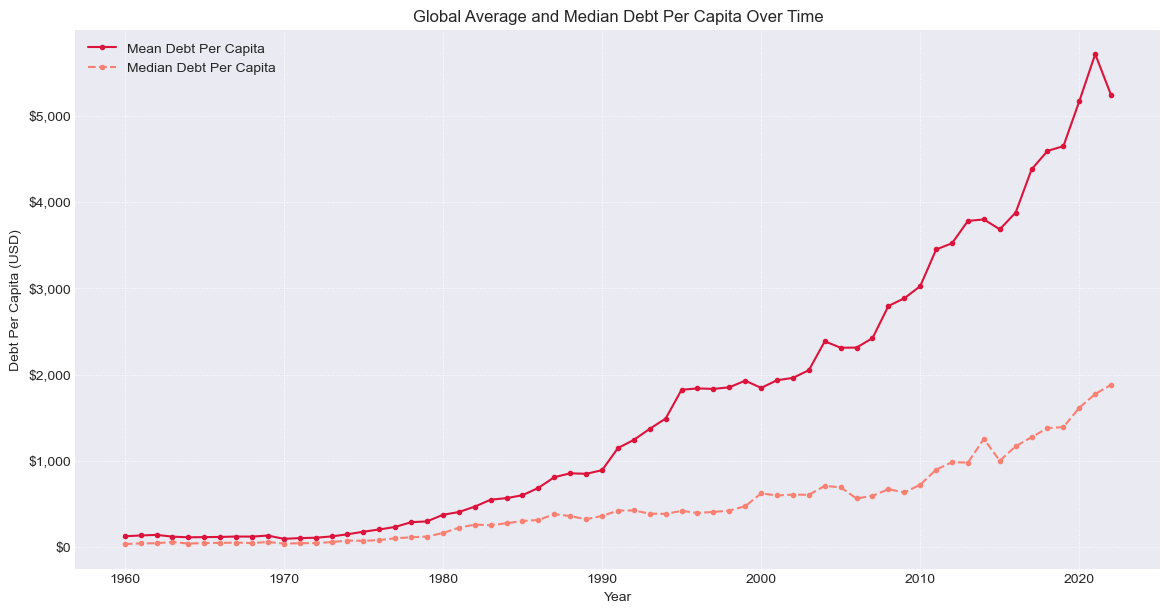

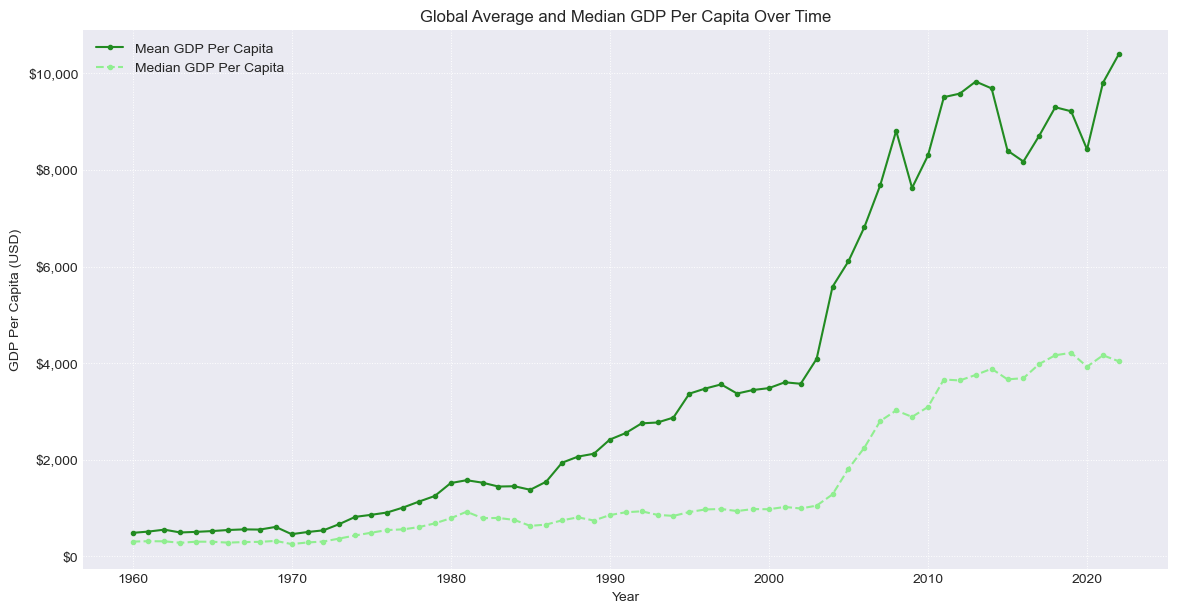


--- 2. Country Rankings for Calculated Metrics (Most Recent Common Year) ---
Analyzing rankings for the latest available year in merged_df: 2022

Top 10 Countries by Debt Per Capita (2022):


,country_name,Debt_Per_Capita,GDP_Per_Capita
3360,qatar,"$39,892","$88,046"
3339,israel,"$32,351","$54,620"
3309,austria,"$31,555","$52,135"
3359,portugal,"$28,745","$24,203"
3311,barbados,"$25,390","$20,019"
3308,australia,"$24,878","$64,404"
3348,malta,"$17,507","$33,449"
3306,argentina,"$11,560","$13,686"
3372,uruguay,"$10,663","$20,795"
3325,dominica,"$9,318","$8,415"



Top 10 Countries by Absolute Debt (2022):


,country_name,Absolute_Debt,Debt_Percentage
3336,india,"$1,876,880,276,556",55.4%
3308,australia,"$647,181,399,984",38.6%
3306,argentina,"$534,473,404,648",84.5%
3337,indonesia,"$520,812,519,467",39.5%
3339,israel,"$309,198,011,187",59.2%
3359,portugal,"$299,222,930,898",118.8%
3309,austria,"$285,312,162,245",60.5%
3310,bangladesh,"$179,883,028,393",39.1%
3357,nigeria,"$166,730,467,584",34.9%
3322,colombia,"$163,278,609,031",47.5%



--- 3. Time-Series Trends for Selected Countries ---
Plotting Debt Per Capita trends for: israel, qatar, india


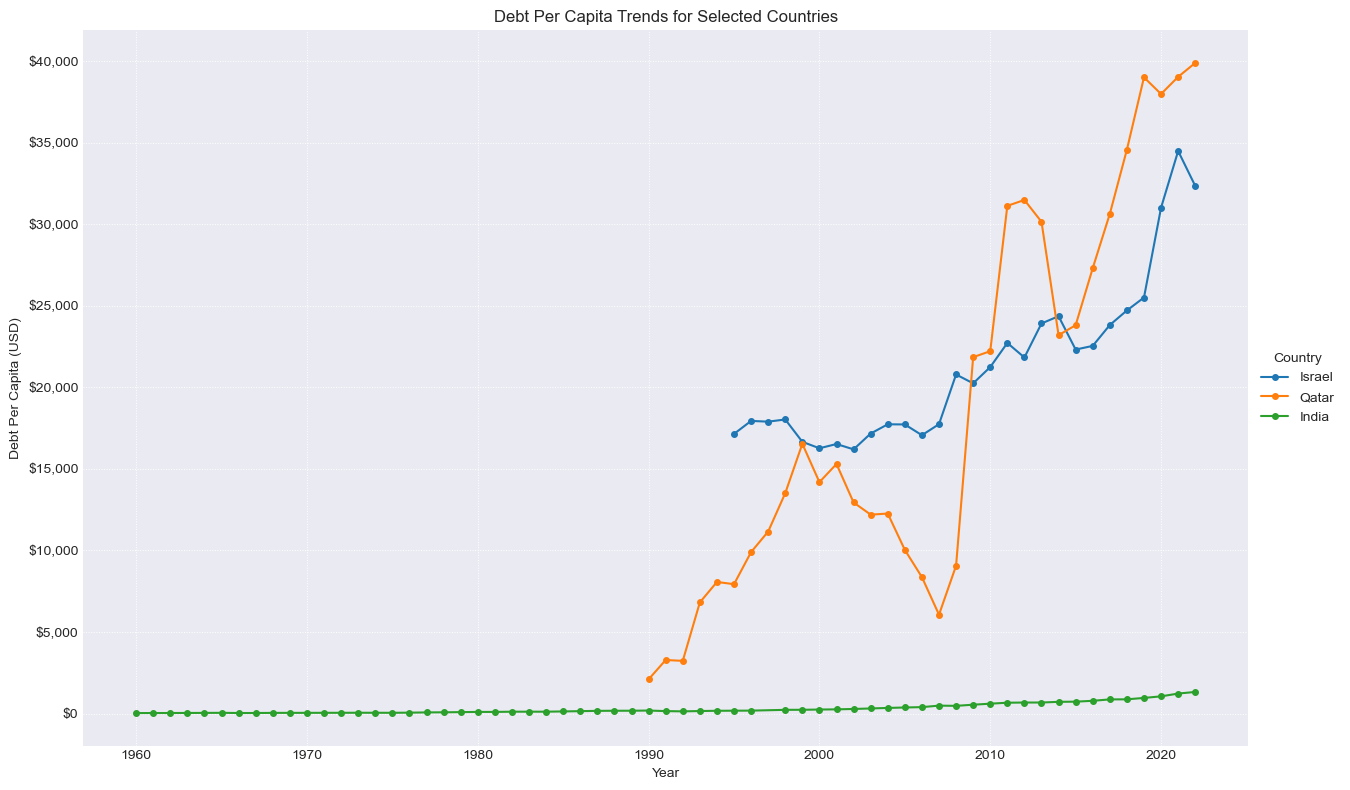


--- 4. Relationship between GDP Per Capita and Debt Per Capita ---


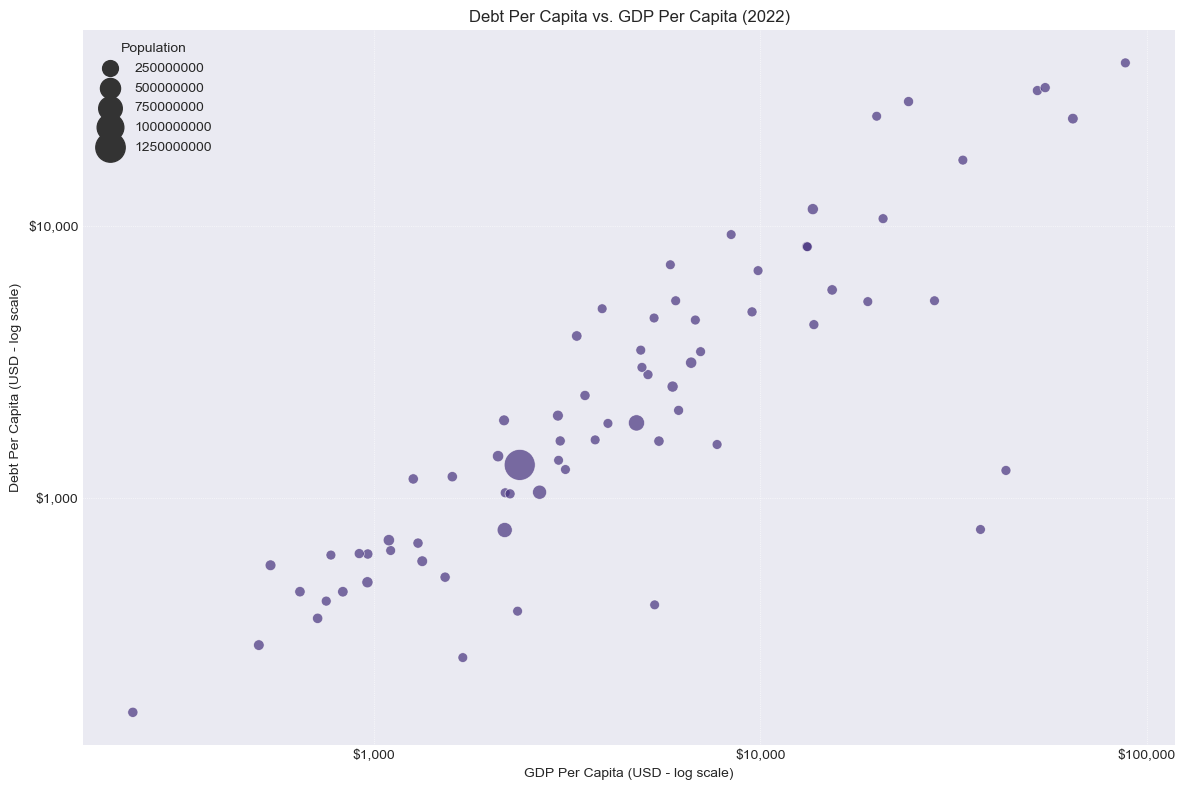

Pearson correlation between GDP Per Capita and Debt Per Capita (2022): 0.84
Pearson correlation between log(GDP Per Capita) and log(Debt Per Capita) (2022): 0.85


In [12]:
import pandas as pd # Ensure pandas is imported
import numpy as np # For potential NaN handling if needed
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from IPython.display import display

print("--- Analysis of Calculated Metrics ---")

# Check that 'merged_df' exists from before and has data
if 'merged_df' not in locals() or merged_df.empty:
    print("Error: 'merged_df' is not available or is empty. Cannot proceed with analysis of calculated metrics.")
# To avoid errors in a long notebook, you can stop here or create empty placeholders
# For now, we’ll just show the error and skip the rest of this cell
else:
    print(f"Analyzing 'merged_df' with shape: {merged_df.shape}")

# Create a function to format numbers as money (USD) for debt and GDP
    def format_usd(value, pos=None):
        if pd.isna(value):
            return "N/A"
        return f"${value:,.0f}" 

    # Overall Trends for Calculated Metrics
    print("\n--- 1. Overall Trends ---")
    
    # Group data by Year and find the average for each metric
    # Simple averages might be affected by outliers or different numbers of countries each year.
    # Using weighted averages (like by population or GDP) would be better but is harder to do.
    yearly_avg_metrics = merged_df.groupby('Year').agg(
        Avg_Absolute_Debt=('Absolute_Debt', 'mean'),
        Avg_Debt_Per_Capita=('Debt_Per_Capita', 'mean'),
        Avg_GDP_Per_Capita=('GDP_Per_Capita', 'mean'),
        Median_Debt_Per_Capita=('Debt_Per_Capita', 'median'), # Adding median for robustness
        Median_GDP_Per_Capita=('GDP_Per_Capita', 'median')
    ).dropna() # Drop years where any of these might be all NaN after grouping

    if not yearly_avg_metrics.empty:
        # Plotting Average Debt Per Capita Over Time
        plt.figure(figsize=(14, 7))
        yearly_avg_metrics['Avg_Debt_Per_Capita'].plot(label='Mean Debt Per Capita', color='crimson', marker='.')
        yearly_avg_metrics['Median_Debt_Per_Capita'].plot(label='Median Debt Per Capita', color='salmon', linestyle='--', marker='.')
        plt.title('Global Average and Median Debt Per Capita Over Time')
        plt.ylabel('Debt Per Capita (USD)')
        plt.xlabel('Year')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_usd))
        plt.legend()
        plt.grid(True, linestyle=':', linewidth=0.7)
        plt.show()

        # Plotting Average GDP Per Capita Over Time
        plt.figure(figsize=(14, 7))
        yearly_avg_metrics['Avg_GDP_Per_Capita'].plot(label='Mean GDP Per Capita', color='forestgreen', marker='.')
        yearly_avg_metrics['Median_GDP_Per_Capita'].plot(label='Median GDP Per Capita', color='lightgreen', linestyle='--', marker='.')
        plt.title('Global Average and Median GDP Per Capita Over Time')
        plt.ylabel('GDP Per Capita (USD)')
        plt.xlabel('Year')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_usd))
        plt.legend()
        plt.grid(True, linestyle=':', linewidth=0.7)
        plt.show()
    else:
        print("Not enough data to plot overall trends for calculated metrics.")

    # Countries with Highest/Lowest Values in a Recent Year 
    print("\n--- 2. Country Rankings for Calculated Metrics (Most Recent Common Year) ---")
    
    # Find the most recent year present in merged_df
    if not merged_df.empty:
        latest_year_merged = merged_df['Year'].max()
        print(f"Analyzing rankings for the latest available year in merged_df: {latest_year_merged}")
        
        data_latest_year_metrics = merged_df[merged_df['Year'] == latest_year_merged].copy()
        data_latest_year_metrics.dropna(subset=['Debt_Per_Capita', 'GDP_Per_Capita', 'Absolute_Debt'], inplace=True)

        if not data_latest_year_metrics.empty:
            # Top 10 by Debt Per Capita
            top_debt_per_capita = data_latest_year_metrics.sort_values('Debt_Per_Capita', ascending=False).head(10)
            print(f"\nTop 10 Countries by Debt Per Capita ({latest_year_merged}):")
            display(top_debt_per_capita[['country_name', 'Debt_Per_Capita', 'GDP_Per_Capita']].style.format({
                'Debt_Per_Capita': format_usd, 'GDP_Per_Capita': format_usd
            }))

            # Top 10 by Absolute Debt
            top_absolute_debt = data_latest_year_metrics.sort_values('Absolute_Debt', ascending=False).head(10)
            print(f"\nTop 10 Countries by Absolute Debt ({latest_year_merged}):")
            display(top_absolute_debt[['country_name', 'Absolute_Debt', 'Debt_Percentage']].style.format({
                'Absolute_Debt': format_usd, 
                'Debt_Percentage': lambda x: format_percentage(x, is_percentage=True) # Use existing format_percentage
            }))
        else:
            print(f"No data available for rankings in year {latest_year_merged} after dropping NaNs from key metrics.")
    else:
        print("merged_df is empty, cannot perform rankings.")


    # Time-Series Trends for Selected Countries 
    print("\n--- 3. Time-Series Trends for Selected Countries ---")
    if not merged_df.empty:
        # Pick some countries to plot — like ones with high debt per person or big economies
        # To be safe, choose countries listed in data_latest_year_metrics if it exists
        countries_to_plot_metrics = []
        if 'data_latest_year_metrics' in locals() and not data_latest_year_metrics.empty:
            if not top_debt_per_capita.empty :
                 countries_to_plot_metrics.extend(top_debt_per_capita['country_name'].unique()[:min(2, len(top_debt_per_capita))].tolist())
            # Add some G20 or other known economies if they are in merged_df
            g20_sample = ['united states', 'china', 'japan', 'germany', 'india', 'brazil', 'united kingdom'] # Standardized names
            available_g20 = [c for c in g20_sample if c in merged_df['country_name'].unique()]
            countries_to_plot_metrics.extend(available_g20[:min(3, len(available_g20))])
            countries_to_plot_metrics = list(set(countries_to_plot_metrics)) # Unique list, max around 5 countries
        
        if not countries_to_plot_metrics: # Fallback if above selection is empty
            countries_to_plot_metrics = merged_df['country_name'].value_counts().nlargest(3).index.tolist()


        if countries_to_plot_metrics:
            print(f"Plotting Debt Per Capita trends for: {', '.join(countries_to_plot_metrics)}")
            plt.figure(figsize=(16, 8))
            palette_metrics = sns.color_palette("tab10", n_colors=len(countries_to_plot_metrics))
            for i, country in enumerate(countries_to_plot_metrics):
                country_metric_data = merged_df[merged_df['country_name'] == country].sort_values('Year')
                if not country_metric_data.empty:
                    plt.plot(country_metric_data['Year'], country_metric_data['Debt_Per_Capita'], 
                             label=country.title(), marker='o', markersize=4, color=palette_metrics[i])
            
            plt.title('Debt Per Capita Trends for Selected Countries')
            plt.ylabel('Debt Per Capita (USD)')
            plt.xlabel('Year')
            plt.gca().yaxis.set_major_formatter(FuncFormatter(format_usd))
            plt.legend(title="Country", loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid(True, linestyle=':', linewidth=0.7)
            plt.tight_layout(rect=[0,0,0.85,1]) # Adjust for the legend
            plt.show()
        else:
            print("Could not select any countries to plot metric trends.")
    else:
        print("merged_df is empty, cannot plot trends for selected countries.")

    # Relationship between GDP Per Capita and Debt Per Capital
    print("\n--- 4. Relationship between GDP Per Capita and Debt Per Capita ---")
    if 'data_latest_year_metrics' in locals() and not data_latest_year_metrics.empty:
        plt.figure(figsize=(12, 8))
        # Use a subset for clarity if too many points, e.g. random sample or filter by region/income
        # For this example, plot all available for the latest year
        plot_data_scatter = data_latest_year_metrics.dropna(subset=['GDP_Per_Capita', 'Debt_Per_Capita'])
        
        if not plot_data_scatter.empty:
            sns.scatterplot(data=plot_data_scatter, x='GDP_Per_Capita', y='Debt_Per_Capita', 
                            hue='income_group' if 'income_group' in plot_data_scatter.columns else None, # Color by income group if available
                            size='Population' if 'Population' in plot_data_scatter.columns else None, # Size by population if available
                            sizes=(50, 500), alpha=0.7, palette="viridis")
            
            plt.title(f'Debt Per Capita vs. GDP Per Capita ({latest_year_merged})')
            plt.xlabel('GDP Per Capita (USD - log scale)')
            plt.ylabel('Debt Per Capita (USD - log scale)')
            plt.xscale('log') # Use log scale due to the wide range of values
            plt.yscale('log')
            plt.gca().xaxis.set_major_formatter(FuncFormatter(format_usd))
            plt.gca().yaxis.set_major_formatter(FuncFormatter(format_usd))
            plt.grid(True, linestyle=':', linewidth=0.5)
            if 'income_group' in plot_data_scatter.columns:
                plt.legend(title='Income Group', loc='center left', bbox_to_anchor=(1, 0.5))
                plt.tight_layout(rect=[0,0,0.85,1])
            else:
                plt.tight_layout()
            plt.show()
            
            # Correlation
            if len(plot_data_scatter) > 1: # Need at least 2 data points to find correlation 
                # Calculate correlation using log values if plotting on log scale, otherwise use original data
                correlation = plot_data_scatter['GDP_Per_Capita'].corr(plot_data_scatter['Debt_Per_Capita'])
                print(f"Pearson correlation between GDP Per Capita and Debt Per Capita ({latest_year_merged}): {correlation:.2f}")
                
                # Correlation using log values, which often shows a clearer relationship
                log_gdp_pc = np.log(plot_data_scatter['GDP_Per_Capita'].replace(0, np.nan).dropna()) # Replace 0 with NaN before log
                log_debt_pc = np.log(plot_data_scatter['Debt_Per_Capita'].replace(0, np.nan).dropna())
                # Align indices if NaNs were dropped differently
                common_idx = log_gdp_pc.index.intersection(log_debt_pc.index)
                if len(common_idx) > 1:
                    log_correlation = log_gdp_pc[common_idx].corr(log_debt_pc[common_idx])
                    print(f"Pearson correlation between log(GDP Per Capita) and log(Debt Per Capita) ({latest_year_merged}): {log_correlation:.2f}")
        else:
            print(f"Not enough data points in year {latest_year_merged} to create scatter plot or calculate correlation.")
            
    else:
        print("Data for the latest year ('data_latest_year_metrics') is not available for scatter plot.")


## 4. Detailed Country Debt Profile Analysis

This section provides a function to generate a detailed debt profile for any selected country. It will display the trend of debt percentages for all available indicators for that country over time, allowing for a focused examination of its fiscal health trajectory using the `processed_debt_df`.



--- Specific Country Debt Profile Function Definition ---

Running example debt profile analysis for countries: Argentina, Guatemala, Australia

--- Generating Debt Percentage Trends for: Argentina ---

Indicators available for Argentina with data: 1
Displaying data for indicators:
  - Annual average of central government debt (Percent of GDP)

Latest Debt Percentages for Argentina by Indicator:


Indicator Name,Latest Year,Debt Percentage
Annual average of central government debt (Percent of GDP),2022,84.5%


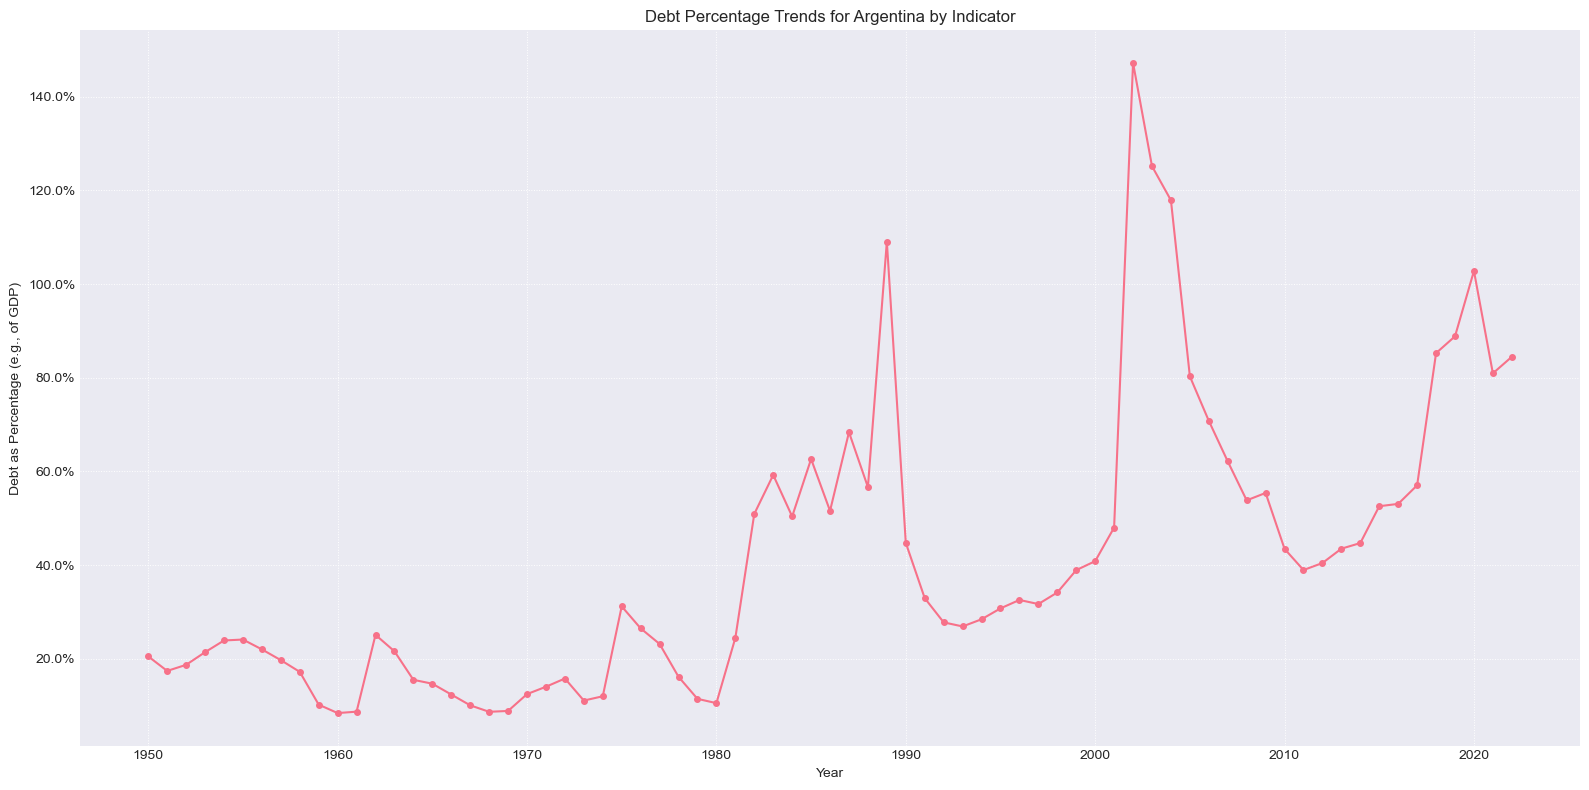


--- Generating Debt Percentage Trends for: Guatemala ---

Indicators available for Guatemala with data: 1
Displaying data for indicators:
  - Annual average of central government debt (Percent of GDP)

Latest Debt Percentages for Guatemala by Indicator:


Indicator Name,Latest Year,Debt Percentage
Annual average of central government debt (Percent of GDP),2022,29.6%


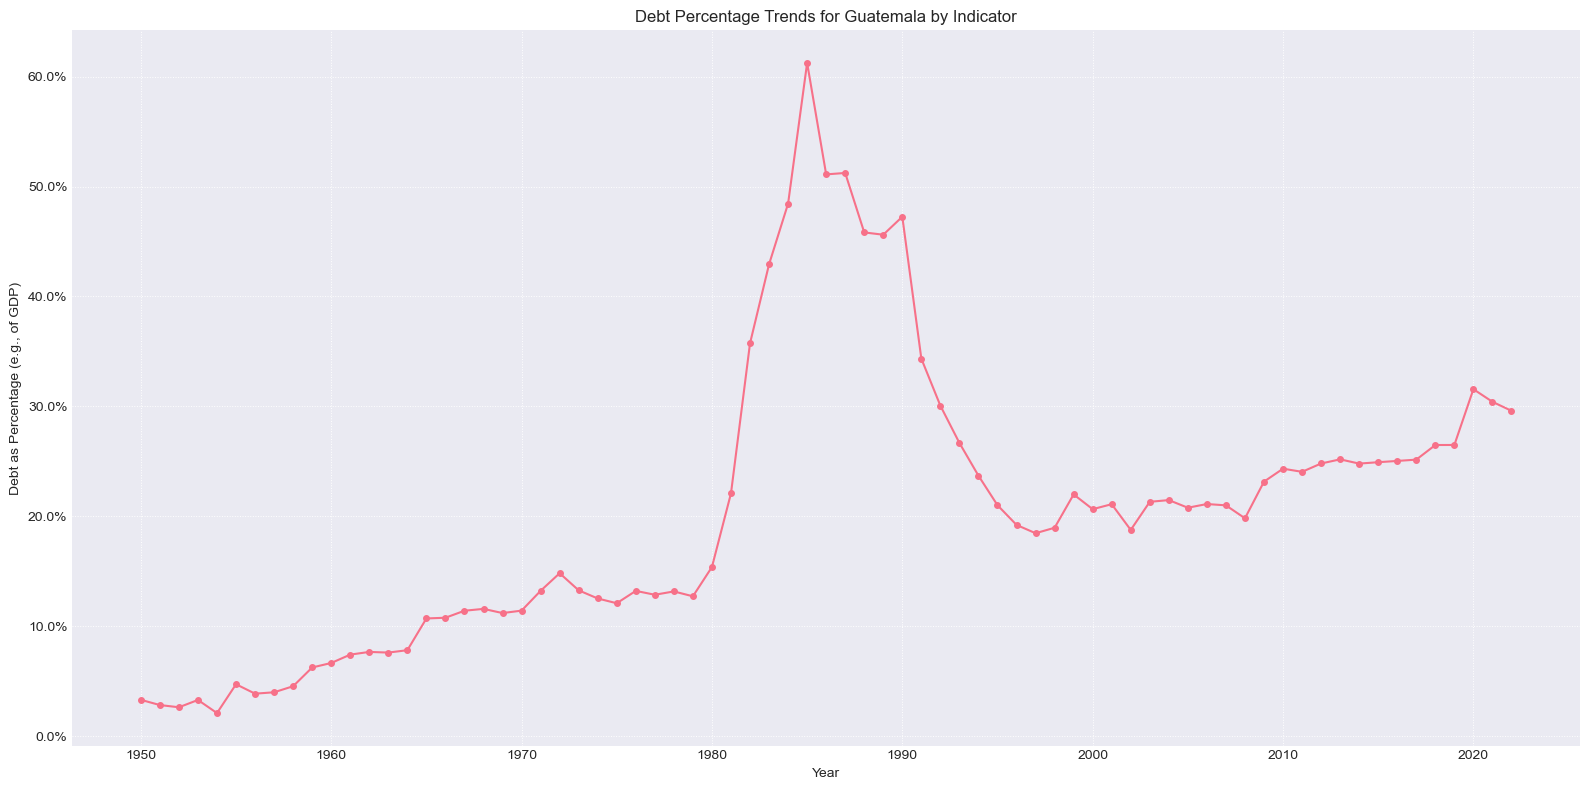


--- Generating Debt Percentage Trends for: Australia ---

Indicators available for Australia with data: 1
Displaying data for indicators:
  - Annual average of central government debt (Percent of GDP)

Latest Debt Percentages for Australia by Indicator:


Indicator Name,Latest Year,Debt Percentage
Annual average of central government debt (Percent of GDP),2022,38.6%


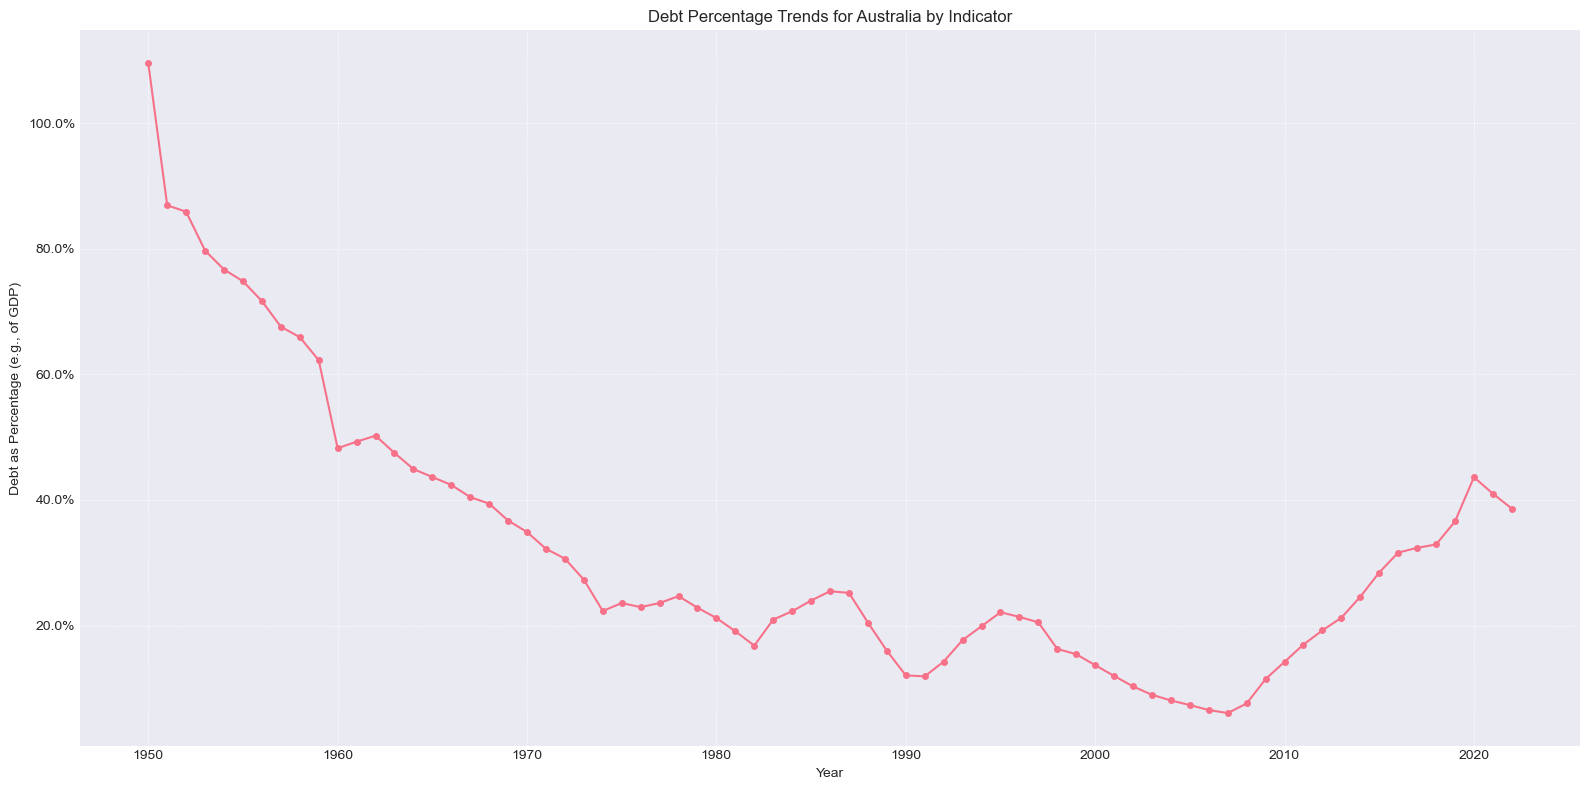

In [13]:
if 'processed_debt_df' not in locals() or processed_debt_df.empty:
    print("Error: 'processed_debt_df' is not available or empty. Skipping Detailed Country Debt Profile section.")
else:
    print(f"\n--- Specific Country Debt Profile Function Definition ---")
    
    def display_country_debt_trends(country_name_param, data_df):
        """
        Displays debt percentage trends for a specific country across all available indicators.
        Args:
            country_name_param (str): The name of the country to analyze.
            data_df (pd.DataFrame): The long-format processed debt dataframe 
                                     (should contain 'country_name', 'Year', 
                                     'indicator_name', 'Debt_Percentage').
        """
        print(f"\n--- Generating Debt Percentage Trends for: {country_name_param} ---")
        
        country_data = data_df[data_df['country_name'].str.lower() == country_name_param.lower()].copy() # Case-insensitive match
        country_data.dropna(subset=['Debt_Percentage'], inplace=True)

        if country_data.empty:
            print(f"No debt percentage data found for {country_name_param} after dropping NaNs.")
            return

        num_indicators_country = country_data['indicator_name'].nunique()
        print(f"\nIndicators available for {country_name_param} with data: {num_indicators_country}")
        
        if num_indicators_country == 0:
            print(f"No indicators with data to plot for {country_name_param}.")
            return
            
        if num_indicators_country <= 15: # Display if not too many for readability
             print("Displaying data for indicators:")
             for indicator in sorted(country_data['indicator_name'].unique()):
                print(f"  - {indicator}")
        else:
            print(f"  (Displaying trends for {num_indicators_country} indicators, list omitted for brevity)")

        # Show the latest debt percentages for each indicator
        latest_year_country_data = country_data.groupby('indicator_name')['Year'].max()
        
        print(f"\nLatest Debt Percentages for {country_name_param} by Indicator:")
        recent_stats_list = []
        for indicator, year_val in latest_year_country_data.items():
            value_series = country_data[
                (country_data['indicator_name'] == indicator) & (country_data['Year'] == year_val)
            ]['Debt_Percentage']
            if not value_series.empty:
                value = value_series.iloc[0]
                recent_stats_list.append({'Indicator Name': indicator, 'Latest Year': year_val, 'Debt Percentage': value})
        
        if recent_stats_list:
            recent_stats_df = pd.DataFrame(recent_stats_list)
            display(recent_stats_df.style.format({
                'Debt Percentage': lambda x: format_percentage(x, is_percentage=True),
                'Latest Year': "{:.0f}"
            }).hide(axis="index"))
        else:
            print(f"No recent data points to display for {country_name_param}.")

        # Plot trends for all indicators for that country
        plt.figure(figsize=(16, 8))
        palette_country_trends = sns.color_palette("husl", n_colors=num_indicators_country) 
        
        plot_successful_country = False
        for i, (name, group) in enumerate(country_data.groupby('indicator_name')):
            if not group.empty:
                group_sorted = group.sort_values('Year')
                plt.plot(group_sorted['Year'], group_sorted['Debt_Percentage'], 
                         label=name, marker='o', markersize=4, linestyle='-', 
                         color=palette_country_trends[i % len(palette_country_trends)])
                plot_successful_country = True
        
        if plot_successful_country:
            plt.title(f'Debt Percentage Trends for {country_name_param.title()} by Indicator')
            plt.xlabel('Year')
            plt.ylabel('Debt as Percentage (e.g., of GDP)')
            plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format_percentage(x, p, is_percentage=True)))
            
            if num_indicators_country > 1: 
                 if num_indicators_country > 7: 
                    plt.legend(title="Indicators", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small')
                    plt.tight_layout(rect=[0,0,0.80,1]) 
                 else:
                    plt.legend(title="Indicators", fontsize='small')
                    plt.tight_layout()
            else:
                plt.tight_layout()

            plt.grid(True, which='both', linestyle=':', linewidth=0.7)
            plt.show()
        else:
            print(f"Could not plot any trends for {country_name_param}. Data might be sparse after filtering.")

    # --- Example ---
    # Make sure that 'processed_debt_df' is available and contains 'country_name'
    if 'processed_debt_df' in locals() and not processed_debt_df.empty and 'country_name' in processed_debt_df.columns:
        available_countries_for_profile = processed_debt_df['country_name'].dropna().unique()
        
        if len(available_countries_for_profile) > 0:
            # Choose a few different countries as examples, focusing on those with interesting debt or more data
            country_data_counts_profile = processed_debt_df.dropna(subset=['Debt_Percentage'])['country_name'].value_counts()
            example_countries_for_profile = country_data_counts_profile.head(min(3, len(country_data_counts_profile))).index.tolist()
            
            # Add a specific country if it’s in the data and interesting, like 'Japan' or 'Greece'
            # Use the exact name from processed_debt_df['country_name']
            # Example:
            # if 'japan' in available_countries_for_profile and 'japan' not in example_countries_for_profile:
            #     example_countries_for_profile.append('japan')
            
            print(f"\nRunning example debt profile analysis for countries: {', '.join(map(str.title, example_countries_for_profile))}")
            for country in example_countries_for_profile:
                display_country_debt_trends(country, processed_debt_df) 
        else:
            print("\nNo countries available in the dataset to run example profile analysis.")
    else:
        print("\n'processed_debt_df' is not available or empty, skipping example country profile analyses.")


## 5. Analysis of Debt Percentage Changes Over Time

This section explores how debt percentages (for the primary debt indicator in `main_indicator_debt_df`) have changed over significant periods. We'll look at average changes per decade and visualize distributions to understand long-term fiscal shifts.



--- Analysis of Debt Percentage Changes Over Time ---
Using indicator: Annual average of central government debt (Percent of GDP)
Analyzing changes across decades: 1960, 1970, 1980, 1990, 2000, 2010, 2020

Countries with Largest Increase in Avg Debt Percentage (1960s to 2020s):


,Avg_Debt_pct_1960s,Avg_Debt_pct_2020s,Change_in_pp
country_name,,,
Japan,7.6%,217.7%,+210.1 p.p.
Greece,16.6%,210.8%,+194.2 p.p.
Singapore,24.9%,147.0%,+122.1 p.p.
Italy,29.4%,145.6%,+116.1 p.p.
Portugal,19.8%,129.1%,+109.3 p.p.
Spain,21.0%,105.4%,+84.4 p.p.
"Bahamas, The",6.4%,87.5%,+81.1 p.p.
Jamaica,19.1%,98.5%,+79.4 p.p.
Argentina,13.4%,89.4%,+76.0 p.p.



Countries with Largest Decrease (or Smallest Increase) in Avg Debt Percentage (1960s to 2020s):


,Avg_Debt_pct_1960s,Avg_Debt_pct_2020s,Change_in_pp
country_name,,,
Ireland,72.4%,59.4%,-13.1 p.p.
New Zealand,56.7%,48.7%,-8.0 p.p.
Norway,22.3%,15.7%,-6.6 p.p.
Australia,44.3%,41.1%,-3.2 p.p.
Switzerland,9.4%,14.0%,+4.6 p.p.
Guyana,23.9%,40.7%,+16.8 p.p.
Denmark,10.5%,28.9%,+18.4 p.p.
India,36.3%,55.1%,+18.8 p.p.
"Türkiye, Republic of",14.1%,33.6%,+19.5 p.p.


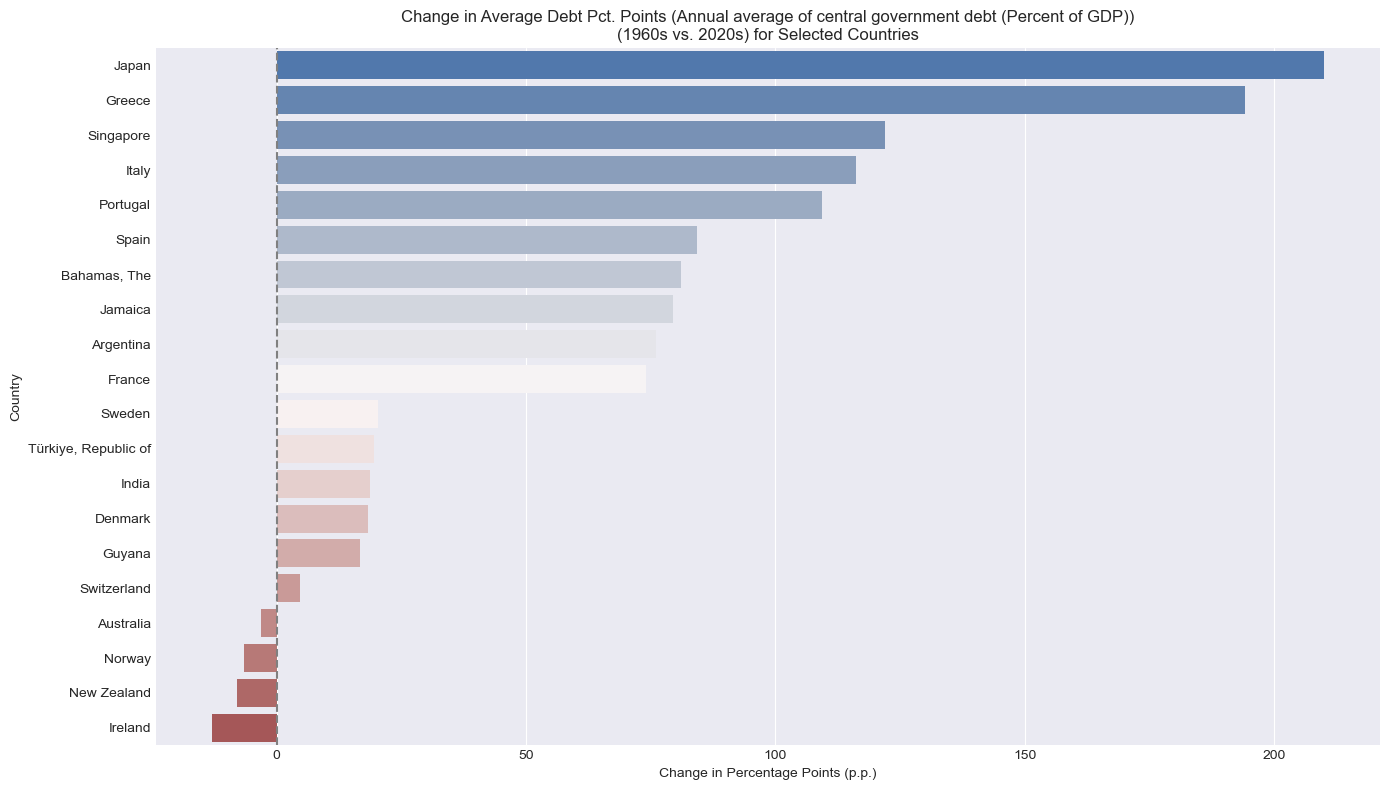

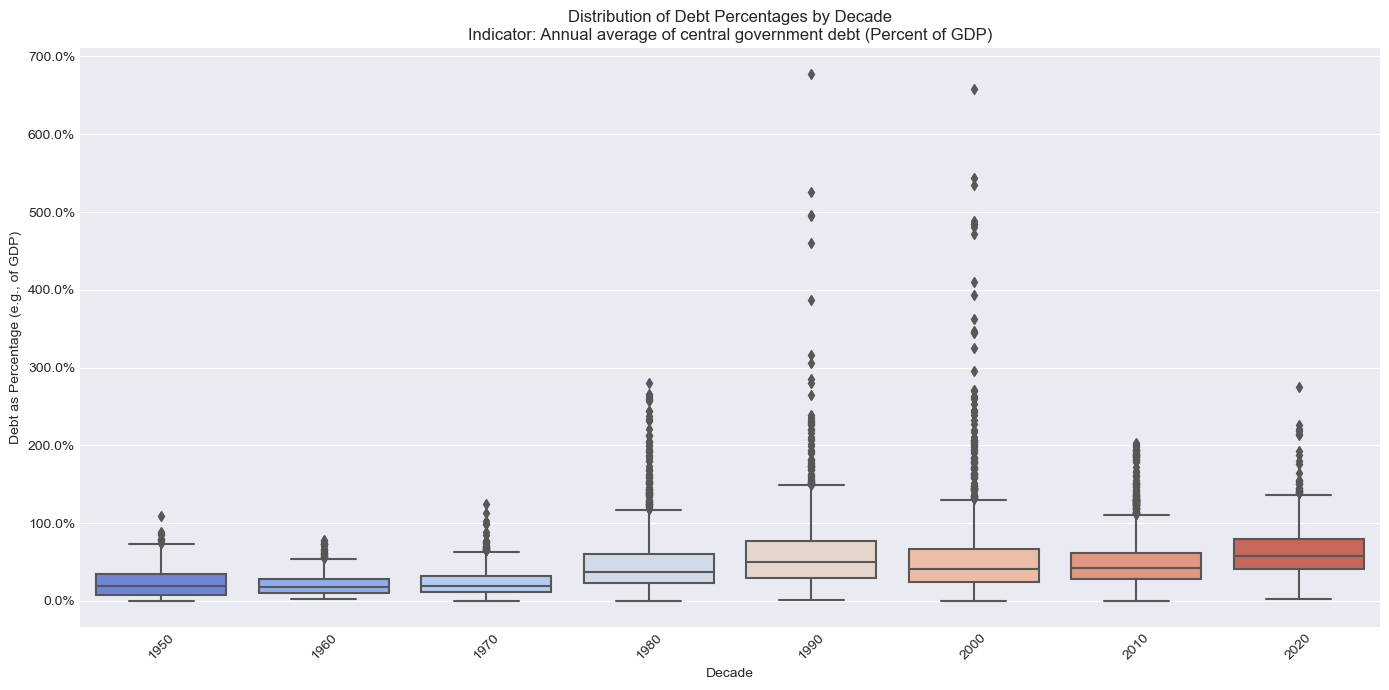

In [14]:
if 'main_indicator_debt_df' not in locals() or main_indicator_debt_df.empty:
    print("Error: 'main_indicator_debt_df' is not available or empty. Skipping Analysis of Debt Percentage Changes.")
else:
    print(f"\n--- Analysis of Debt Percentage Changes Over Time ---")
    current_indicator_changes = main_indicator_debt_df['indicator_name'].iloc[0]
    print(f"Using indicator: {current_indicator_changes}")

    # Add a 'Decade' column
    # Use .copy() to avoid warnings if main_indicator_debt_df is just a part of the data
    main_indicator_debt_df_for_changes = main_indicator_debt_df.copy()
    main_indicator_debt_df_for_changes['Decade'] = (main_indicator_debt_df_for_changes['Year'] // 10) * 10
    
    min_analysis_year_decadal = main_indicator_debt_df_for_changes['Year'].min()
    max_analysis_year_decadal = main_indicator_debt_df_for_changes['Year'].max()
    
    # Keep only decades with enough data, starting from around 1960 or 1970 and up to recent years
    start_decade_analysis = max(1960, (min_analysis_year_decadal // 10) * 10)
    end_decade_analysis = (max_analysis_year_decadal // 10) * 10

    decades_to_analyze = sorted([
        d for d in main_indicator_debt_df_for_changes['Decade'].unique() 
        if d >= start_decade_analysis and d <= end_decade_analysis
    ])

    if len(decades_to_analyze) >= 2:
        print(f"Analyzing changes across decades: {', '.join(map(str, decades_to_analyze))}")

        decadal_avg_debt = main_indicator_debt_df_for_changes[
            main_indicator_debt_df_for_changes['Decade'].isin(decades_to_analyze)
        ].groupby(['country_name', 'Decade'])['Debt_Percentage'].mean().unstack()

        # Calculate change from the first analyzed decade to the last analyzed decade
        first_decade_in_analysis = decades_to_analyze[0]
        last_decade_in_analysis = decades_to_analyze[-1]
        
        first_decade_data = decadal_avg_debt[first_decade_in_analysis].dropna()
        last_decade_data = decadal_avg_debt[last_decade_in_analysis].dropna()
        
        common_countries_decadal = first_decade_data.index.intersection(last_decade_data.index)
        
        if not common_countries_decadal.empty and len(common_countries_decadal) > 1:
            change_df = pd.DataFrame({
                f'Avg_Debt_pct_{first_decade_in_analysis}s': first_decade_data.loc[common_countries_decadal],
                f'Avg_Debt_pct_{last_decade_in_analysis}s': last_decade_data.loc[common_countries_decadal]
            })
            change_df['Change_in_pp'] = change_df[f'Avg_Debt_pct_{last_decade_in_analysis}s'] - change_df[f'Avg_Debt_pct_{first_decade_in_analysis}s']
            change_df.sort_values('Change_in_pp', ascending=False, inplace=True)

            print(f"\nCountries with Largest Increase in Avg Debt Percentage ({first_decade_in_analysis}s to {last_decade_in_analysis}s):")
            display(change_df.head(10).style.format({
                f'Avg_Debt_pct_{first_decade_in_analysis}s': lambda x: format_percentage(x, is_percentage=True),
                f'Avg_Debt_pct_{last_decade_in_analysis}s': lambda x: format_percentage(x, is_percentage=True),
                'Change_in_pp': lambda x: f"{x:+.1f} p.p."
            }))

            print(f"\nCountries with Largest Decrease (or Smallest Increase) in Avg Debt Percentage ({first_decade_in_analysis}s to {last_decade_in_analysis}s):")
            display(change_df.tail(10).sort_values('Change_in_pp', ascending=True).style.format({
                f'Avg_Debt_pct_{first_decade_in_analysis}s': lambda x: format_percentage(x, is_percentage=True),
                f'Avg_Debt_pct_{last_decade_in_analysis}s': lambda x: format_percentage(x, is_percentage=True),
                'Change_in_pp': lambda x: f"{x:+.1f} p.p."
            }))

            # Visualization of the changes
            top_n_changes_display = min(10, len(change_df) // 2 if len(change_df) >= 4 else len(change_df)) # Show up to 10 top and 10 bottom if enough data
            if top_n_changes_display > 0 :
                plot_change_df_viz = pd.concat([
                    change_df.head(top_n_changes_display),
                    change_df.tail(top_n_changes_display)
                ]).sort_values('Change_in_pp', ascending=False) # Ensure it's sorted for visual

                plt.figure(figsize=(14, 8))
                sns.barplot(data=plot_change_df_viz, x='Change_in_pp', y=plot_change_df_viz.index, palette="vlag")
                plt.title(f'Change in Average Debt Pct. Points ({current_indicator_changes})\n({first_decade_in_analysis}s vs. {last_decade_in_analysis}s) for Selected Countries')
                plt.xlabel('Change in Percentage Points (p.p.)')
                plt.ylabel('Country')
                plt.axvline(0, color='grey', linestyle='--')
                plt.tight_layout()
                plt.show()
            else:
                print("Not enough countries with consistent decadal data to visualize changes.")

        else:
            print("Not enough common countries with data in both the earliest and latest analyzed decades to show significant changes.")
            
        # Boxplot of debt percentages by decade
        plt.figure(figsize=(14, 7))
        decade_value_counts = main_indicator_debt_df_for_changes['Decade'].value_counts()
        # Only include decades with a reasonable number of data points for the boxplot
        valid_decades_for_boxplot_viz = decade_value_counts[decade_value_counts >= 10].index.sort_values()
        
        if len(valid_decades_for_boxplot_viz) > 1:
            boxplot_data_viz = main_indicator_debt_df_for_changes[
                main_indicator_debt_df_for_changes['Decade'].isin(valid_decades_for_boxplot_viz)
            ]
            sns.boxplot(data=boxplot_data_viz, x='Decade', y='Debt_Percentage', palette="coolwarm", order=valid_decades_for_boxplot_viz)
            plt.title(f'Distribution of Debt Percentages by Decade\nIndicator: {current_indicator_changes}')
            plt.xlabel('Decade')
            plt.ylabel('Debt as Percentage (e.g., of GDP)')
            plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format_percentage(x, p, is_percentage=True)))
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough decades with sufficient data to create a comparative boxplot.")
            
    else:
        print("Not enough distinct decades with data to perform change analysis.")


## 6. Examination of Indicator Diversity

This section examines the `indicator_name` column from the full `processed_debt_df` to understand the types of data present in the `central_government_debt.csv` file. If multiple distinct indicators related to debt percentages are found, we will compare their characteristics. If the dataset predominantly features one primary debt indicator, this section will confirm its prevalence and provide summary statistics.


In [15]:
if 'processed_debt_df' not in locals() or processed_debt_df.empty:
    print("Error: 'processed_debt_df' is not available. Skipping Examination of Indicator Diversity.")
else:
    print(f"\n--- Examination of Indicator Diversity ---")
    
    # Drop rows where indicator_name might be NaN before getting unique values or counts
    processed_debt_df_with_indicators = processed_debt_df.dropna(subset=['indicator_name'])
    
    if processed_debt_df_with_indicators.empty:
        print("No indicators found after dropping rows with missing indicator names.")
    else:
        unique_indicators_list_all = processed_debt_df_with_indicators['indicator_name'].unique()
        num_unique_all_indicators = len(unique_indicators_list_all)
        print(f"Found {num_unique_all_indicators} unique indicator name(s) in the dataset.")

        if num_unique_all_indicators == 0:
            print("No indicator names found in the dataset (this case should be caught by previous check).")
        elif num_unique_all_indicators == 1:
            single_indicator_name = unique_indicators_list_all[0]
            print(f"The dataset predominantly contains one indicator: '{single_indicator_name}'.")
            
            single_indicator_data_summary = processed_debt_df_with_indicators[
                processed_debt_df_with_indicators['indicator_name'] == single_indicator_name
            ].copy()
            single_indicator_data_summary.dropna(subset=['Debt_Percentage'], inplace=True)
            
            if not single_indicator_data_summary.empty:
                print(f"\nSummary Statistics for '{single_indicator_name}':")
                print(f"  Total Data Points (country-year observations): {len(single_indicator_data_summary)}")
                print(f"  Number of Countries Covered: {single_indicator_data_summary['country_name'].nunique()}")
                print(f"  Time Range: {single_indicator_data_summary['Year'].min()} - {single_indicator_data_summary['Year'].max()}")
                print(f"  Overall Mean Debt Percentage: {format_percentage(single_indicator_data_summary['Debt_Percentage'].mean(), is_percentage=True)}")
                print(f"  Overall Median Debt Percentage: {format_percentage(single_indicator_data_summary['Debt_Percentage'].median(), is_percentage=True)}")
                print(f"  Overall Min Debt Percentage: {format_percentage(single_indicator_data_summary['Debt_Percentage'].min(), is_percentage=True)}")
                print(f"  Overall Max Debt Percentage: {format_percentage(single_indicator_data_summary['Debt_Percentage'].max(), is_percentage=True)}")
            else:
                print(f"No non-NaN data points found for the indicator '{single_indicator_name}'.")
                
        else: # Multiple indicators exist
            print("\nMultiple indicators found. Displaying value counts and summary statistics for top indicators.")
            
            indicator_value_counts_all = processed_debt_df_with_indicators['indicator_name'].value_counts()
            print("\nValue Counts of Indicators (Number of Rows per Indicator):")
            display(indicator_value_counts_all)

            # Summary stats for top few indicators
            top_n_for_stats = min(5, num_unique_all_indicators)
            print(f"\nSummary Statistics for Top {top_n_for_stats} Indicators (by data point availability):")
            
            for indicator_name_stats in indicator_value_counts_all.head(top_n_for_stats).index:
                indicator_subset_stats = processed_debt_df_with_indicators[
                    processed_debt_df_with_indicators['indicator_name'] == indicator_name_stats
                ].copy()
                indicator_subset_stats.dropna(subset=['Debt_Percentage'], inplace=True)
                
                if not indicator_subset_stats.empty:
                    print(f"\n  Indicator: '{indicator_name_stats}'")
                    print(f"    Data Points: {len(indicator_subset_stats)}")
                    print(f"    Countries: {indicator_subset_stats['country_name'].nunique()}")
                    print(f"    Years: {indicator_subset_stats['Year'].min()}-{indicator_subset_stats['Year'].max()}")
                    print(f"    Mean Debt %: {format_percentage(indicator_subset_stats['Debt_Percentage'].mean(), is_percentage=True)}")
                    print(f"    Median Debt %: {format_percentage(indicator_subset_stats['Debt_Percentage'].median(), is_percentage=True)}")
                else:
                    print(f"\n  Indicator: '{indicator_name_stats}' - No non-NaN data points for Debt_Percentage.")
            
            # Attempt to plot trends for the top few most common indicators if they have enough data
            print("\nPlotting mean trends for the most common indicators (if sufficient data)...")
            indicators_for_trend_plot_multi = indicator_value_counts_all.head(min(4, num_unique_all_indicators)).index.tolist()

            if indicators_for_trend_plot_multi:
                plt.figure(figsize=(16, 8))
                palette_multi_indicator_trends = sns.color_palette("tab10", n_colors=len(indicators_for_trend_plot_multi))
                plotted_any_trend = False
                for i, indicator_name_trend in enumerate(indicators_for_trend_plot_multi):
                    indicator_trend_data_plot = processed_debt_df_with_indicators[
                        processed_debt_df_with_indicators['indicator_name'] == indicator_name_trend
                    ].copy()
                    indicator_trend_data_plot.dropna(subset=['Debt_Percentage'], inplace=True)
                    
                    if not indicator_trend_data_plot.empty:
                        mean_trend_plot = indicator_trend_data_plot.groupby('Year')['Debt_Percentage'].mean()
                        # Only plot if there are enough points to make a meaningful trend line
                        if len(mean_trend_plot) > 5 : # Heuristic: need more than 5 years of data
                            plt.plot(mean_trend_plot.index, mean_trend_plot.values, 
                                     label=indicator_name_trend, marker='.', markersize=5, 
                                     color=palette_multi_indicator_trends[i % len(palette_multi_indicator_trends)])
                            plotted_any_trend = True
                
                if plotted_any_trend:
                    plt.title(f'Mean Debt Percentage Trends for Most Common Indicators')
                    plt.ylabel('Mean Debt as Percentage (e.g., of GDP)')
                    plt.xlabel('Year')
                    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format_percentage(x, p, is_percentage=True)))
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Indicator Name", fontsize='small')
                    plt.grid(True, which='both', linestyle=':', linewidth=0.7)
                    plt.tight_layout(rect=[0,0,0.80,1]) # Adjust layout for legend
                    plt.show()
                else:
                    print("Not enough distinct indicators with sufficient yearly data to plot meaningful trends.")
            else:
                print("No indicators identified for trend plotting.")



--- Examination of Indicator Diversity ---
Found 1 unique indicator name(s) in the dataset.
The dataset predominantly contains one indicator: 'Annual average of central government debt (Percent of GDP)'.

Summary Statistics for 'Annual average of central government debt (Percent of GDP)':
  Total Data Points (country-year observations): 8116
  Number of Countries Covered: 173
  Time Range: 1950 - 2022
  Overall Mean Debt Percentage: 47.9%
  Overall Median Debt Percentage: 37.6%
  Overall Min Debt Percentage: 0.0%
  Overall Max Debt Percentage: 677.2%


## 7. Key Findings and Recommendations

While this notebook gives a good look at government debt and the economy, there are some limits to keep in mind:

1.  **Data Availability and Consistency:**
    * The data covers a lot but is missing some info for certain countries or years. This can make it hard to compare over time or between countries.
    * We mostly used the main debt indicator (like "debt as % of GDP") for analysis. Other types of debt data might have less info and weren’t studied as much.
    * Country names need to match exactly across files to join the data correctly. We cleaned names by making them lowercase and removing spaces, but some mismatches might still happen. Using country codes (like ISO codes) could help fix this.

2.  **Indicator Definitions:**
    * The debt data shows debt as a percentage. We assumed this means debt compared to GDP. If the percentages are based on different things, the calculations might be off.
    * GDP data was taken as “GDP in current US dollars.” If other GDP types (like adjusted for inflation) were better for some analyses, results could change.

3.  **Scope of "Debt":**
    * The debt data only looks at central government debt. It doesn’t include state or local government debt, debts from public companies, or private debt, which also maT.
    * We tried to look at debt types (like who the debt is owed to) but the data wasn’t detailed enough to do this well.

4.  **Causality vs. CorrelFn:**
    * We found some patterns and connections (for example, between GDP per person and debt per person). But just because two things happen together doesn’t mean one causes the other. More advanced analysis would be needed to prove cause and effect.

5.  **External Factors:**
    * This study only used the given data. It doesn’t directly include big world events (like financial crashes, pandemics, or wars) or government policies, although some trends might show their effects.

6.  **Aggregation MIhods:**
    * When we calculated averages (like averIe debt per person), we just used simple averages. Using weighted averages (like by population size) might s

To improve this analysisToImprove this analysis, we’d need more detailed data and more advanced methods.
 analytical techniques.


## 6. Future Work


Building on what I have now, here are some ways to make the analysis better and learn more:

1.  **Better Time Series Analysis:**
    * Use more advanced time-series methods (like ARIMA or VAR) to predict future debt trends and see how debt, GDP, and population affect each other over time.
    * Find big changes in debt patterns and link them to important economic or political events.

2.  **Add More External Data:**
    * Add more economic data like inflation, interest rates, trade balances, government budgets, and how good the government is, to better understand what affects debt.
    * Combine with more detailed debt data (like what part is domestic or foreign, types of creditors) if it becomes available to get a clearer picture of debt risks.
    * Include info on how countries pay back debt to see if their debt is sustainable.

3.  **Better Risk Analysis:**
    * Use or create models to analyze how likely countries are to face debt problems.
    * Try machine learning to predict which countries might get into trouble based on many factors.

4.  **More Detailed Sector Analysis:**
    * If possible, include debt from state/local governments, public companies, and private sectors to see the full national debt picture.

5.  **Improved Visuals and Interactivity:**
    * Build interactive dashboards so users can explore the data by choosing countries, time periods, and indicators.
    * Make better maps to show debt patterns in different regions.

6.  **Compare Country Groups:**
    * Compare groups of countries (like by income level, region, or development status) and test for differences in their debt trends.

7.  **Analyze Effects of Big Events:**
    * Measure how big shocks like the 2008 financial crisis or COVID-19 affected debt using special event study methods or econometric models.
uantify the impact of major global or regional shocks (e.g., 2008 financial crisis, COVID-19 pandemic) on debt metrics using event study methodologies or econometric modeling.


## Conclusion

This notebook looked closely at global government debt over time, using data on debt as a percent of GDP and combining it with GDP and population numbers to get better ideas like total debt and debt per person.

**Main points from the analysis are:**

* **How Debt Changed Over Time:** We saw how government debt as a percent of GDP changed over many years, showing the average and middle values worldwide.
* **Debt Differences by Country:** The study showed big differences in debt levels between countries, pointing out which have very high or very low debt recently. We also looked at how debt changed over time in some countries.
* **How Economy Affects Debt:** By calculating total debt and debt per person, we got a clearer picture of how much debt really means compared to the size of the economy and population. For example, the link between how rich a country is and how much debt people have changes a lot depending on income levels.
* **Long-Term Changes:** Looking at debt changes by decade helped us understand how countries’ debt levels grew or shrank over time.

Changing the debt numbers from just percentages to total and per person amounts, based on GDP and population, gives a fuller picture. It shows why it’s important to think about both the size of the economy and the number of people when looking at debt.

Even though the analysis had limits because of the data available, it showed a way to study debt in a detailed way. The patterns found can help policymakers, economists, and researchers who want to understand public money and the world economy better. Future work could use more data and better models to learn even more about government debt.
reign debt.
